In [1]:
import kagglehub

# # Download latest version
path = kagglehub.dataset_download("shubhammeshram579/bank-customer-churn-prediction", 
                                  path="Churn_Modelling.csv")

print("Path to dataset files:", path)

d:\shap-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\himan\.cache\kagglehub\datasets\shubhammeshram579\bank-customer-churn-prediction\versions\1\Churn_Modelling.csv


In [2]:
import pandas as pd
import numpy as np
import shap
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set config

set_config(transform_output="pandas")

In [4]:
# load the data

df = pd.read_csv(path)

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [5]:
# shape of the data

df.shape

(10002, 14)

In [6]:
# check for missing values

df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
df.isna().any(axis=1)

0        False
1        False
2        False
3        False
4         True
         ...  
9997     False
9998     False
9999     False
10000    False
10001    False
Length: 10002, dtype: bool

In [8]:
# find the rows having missing values

(
    df.loc[
        (df.isna().any(axis=1)), :
    ]
)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
6,7,15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
8,9,15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,10,15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0


In [9]:
# drop the missing rows

df.dropna(inplace=True)

In [10]:
# missing values

df.isna().sum().sum()

np.int64(0)

In [11]:
# check for duplicates

df.duplicated().sum()

np.int64(2)

In [12]:
# duplicate rows

(
    df
    .loc[
        df.duplicated(keep=False), :
    ]
    
)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0
10001,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [13]:
# drop the duplicate rows

df.drop_duplicates(inplace=True)

In [14]:
# duplicates

df.duplicated().sum()

np.int64(0)

## EDA

In [15]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,6,15574012,Chu,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [16]:
# drop the first three columns

columns_to_drop = df.columns[0:3]

columns_to_drop

Index(['RowNumber', 'CustomerId', 'Surname'], dtype='object')

In [17]:
# drop the columns

df.drop(columns=columns_to_drop, inplace=True)

In [18]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [19]:
# lowercase the column names

df.rename(columns=str.lower, inplace=True)

In [20]:
df.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [21]:
# make our X and y

X = df.drop(columns=["exited"])

y = df["exited"]

In [22]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52


In [23]:
y

0        1
1        0
2        1
3        0
5        1
        ..
9995     0
9996     0
9997     1
9998     1
10000    0
Name: exited, Length: 9996, dtype: int64

In [24]:
# datatype

df.dtypes

creditscore          int64
geography           object
gender              object
age                float64
tenure               int64
balance            float64
numofproducts        int64
hascrcard          float64
isactivemember     float64
estimatedsalary    float64
exited               int64
dtype: object

In [25]:
# list of columns

numerical_cols = ["creditscore", "age", "balance", "estimatedsalary"]

categorical_cols = ["gender", "geography"]

In [26]:
numerical_cols

['creditscore', 'age', 'balance', 'estimatedsalary']

In [27]:
remainder_cols = [column_name for column_name in X.columns if column_name not in numerical_cols + categorical_cols]

remainder_cols

['tenure', 'numofproducts', 'hascrcard', 'isactivemember']

In [28]:
df[numerical_cols]

,creditscore,age,balance,estimatedsalary
0,619,42.0,0.00,101348.88
1,608,41.0,83807.86,112542.58
2,502,42.0,159660.80,113931.57
3,699,39.0,0.00,93826.63
5,645,44.0,113755.78,149756.71
...,...,...,...,...
9995,771,39.0,0.00,96270.64
9996,516,35.0,57369.61,101699.77
9997,709,36.0,0.00,42085.58
9998,772,42.0,75075.31,92888.52


In [29]:
df[categorical_cols]

,gender,geography
0,Female,France
1,Female,Spain
2,Female,France
3,Female,France
5,Male,Spain
...,...,...
9995,Male,France
9996,Male,France
9997,Female,France
9998,Male,Germany


In [30]:
df[remainder_cols]

,tenure,numofproducts,hascrcard,isactivemember
0,2,1,1.0,1.0
1,1,1,0.0,1.0
2,8,3,1.0,0.0
3,1,2,0.0,0.0
5,8,2,1.0,0.0
...,...,...,...,...
9995,5,2,1.0,0.0
9996,10,1,1.0,1.0
9997,7,1,0.0,1.0
9998,3,2,1.0,0.0


In [31]:
from matplotlib.gridspec import GridSpec

In [32]:
def plots_for_numerical_columns(column_name, bins, kde=True):
    # set the figure size
    fig = plt.figure(figsize=(8,6))
    # gridspec
    grid = GridSpec(nrows=2, ncols=2, height_ratios=[0.6,0.4])
    
    # define the axes
    ax1 = plt.subplot(grid[0,:])
    ax2 = plt.subplot(grid[1,:])
    
    # plot the histogram
    sns.histplot(data=X, x=column_name, bins=bins, kde=kde, ax=ax1)
    
    # plot the boxplot
    sns.boxplot(data=df,x=column_name,ax=ax2)
    
    plt.show()

In [33]:
# bins for the histogram

col_bins = {
    column_name:bin_val for column_name, bin_val in zip(numerical_cols, [50,15,"auto","auto"])
}

col_bins

{'creditscore': 50, 'age': 15, 'balance': 'auto', 'estimatedsalary': 'auto'}

Creditscore



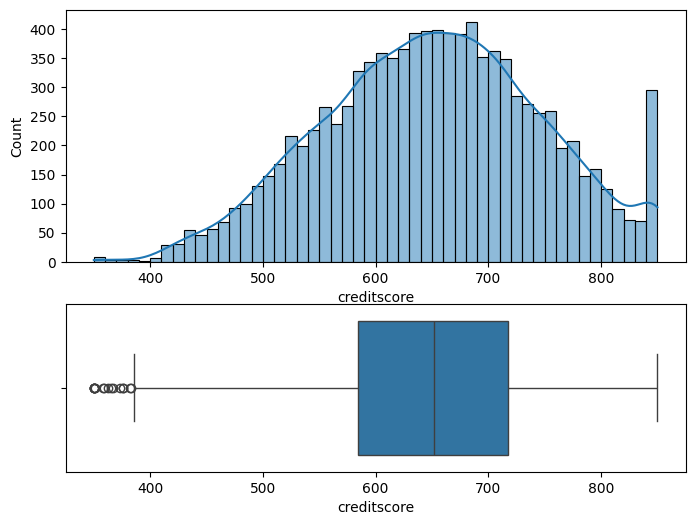




Age



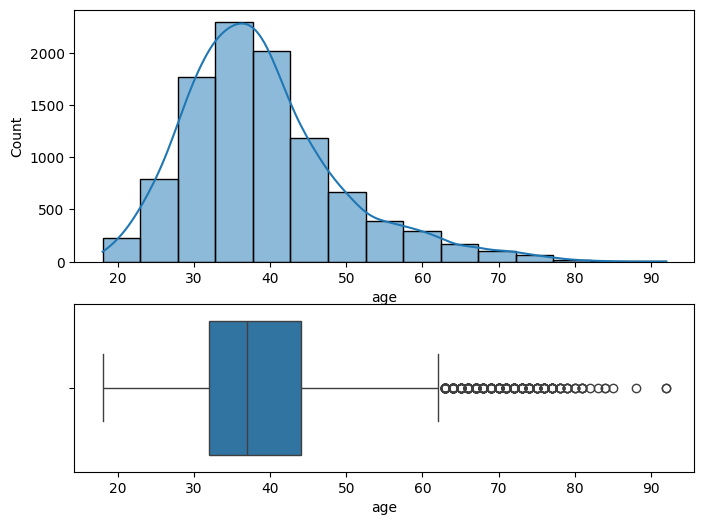




Balance



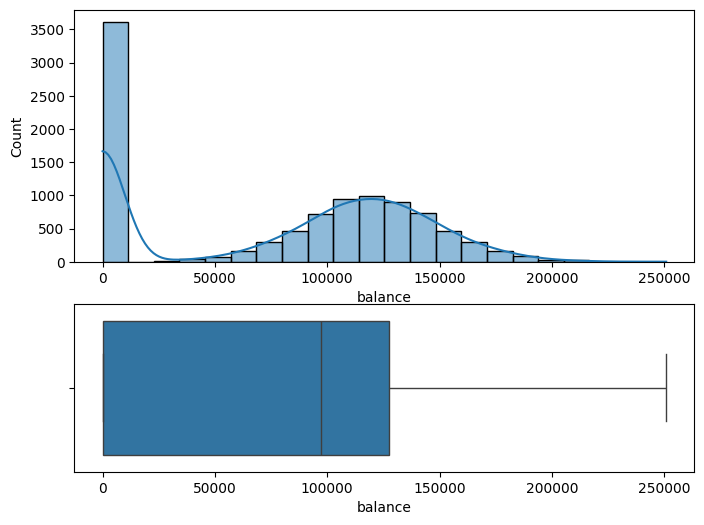




Estimatedsalary



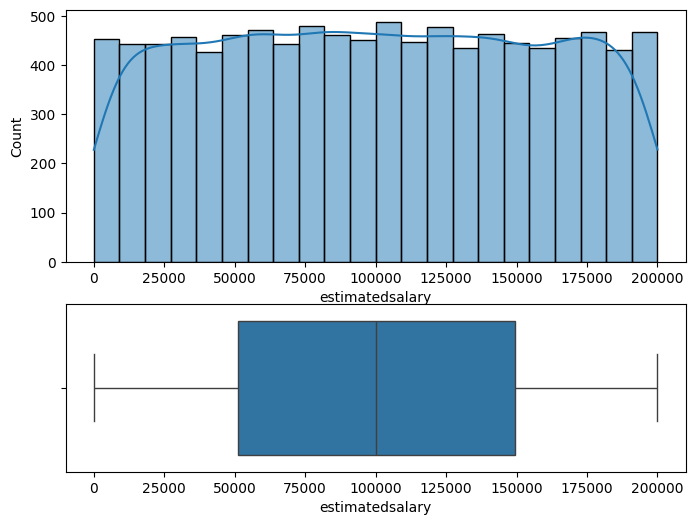

In [34]:
for num_col in numerical_cols:
    print(f"{num_col.title()}", end="\n\n")
    plots_for_numerical_columns(column_name=num_col, bins=col_bins[num_col])
    print("\n\n")

In [35]:
# people with 0 bal

(
    X.loc[
        (X["balance"].eq(0)), :
    ]
)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary
0,619,France,Female,42.0,2,0.0,1,1.0,1.0,101348.88
3,699,France,Female,39.0,1,0.0,2,0.0,0.0,93826.63
11,497,Spain,Male,24.0,3,0.0,2,1.0,0.0,76390.01
12,476,France,Female,34.0,10,0.0,2,1.0,0.0,26260.98
13,549,France,Female,25.0,5,0.0,2,0.0,0.0,190857.79
...,...,...,...,...,...,...,...,...,...,...
9989,841,Spain,Male,28.0,4,0.0,2,1.0,1.0,179436.60
9992,726,Spain,Male,36.0,2,0.0,1,1.0,0.0,195192.40
9994,800,France,Female,29.0,2,0.0,2,0.0,0.0,167773.55
9995,771,France,Male,39.0,5,0.0,2,1.0,0.0,96270.64


In [36]:
X["balance"].eq(0)

0         True
1        False
2        False
3         True
5        False
         ...  
9995      True
9996     False
9997      True
9998     False
10000    False
Name: balance, Length: 9996, dtype: bool

In [37]:
# new col for 0 bal customers

X["iszerobal"] = X["balance"].eq(0).astype(int)

In [38]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,iszerobal
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,0
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,1
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,1
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0


In [39]:
def plots_for_categorical_cols(column_name):
    display(X[column_name].value_counts(normalize=True))
    print(f"There are {X[column_name].nunique()} unique values in the column {column_name} which are {X[column_name].unique()}")
    # plot the count plot
    sns.countplot(data=X,x=column_name)
    plt.show()

Gender


gender
Male      0.545618
Female    0.454382
Name: proportion, dtype: float64

There are 2 unique values in the column gender which are ['Female' 'Male']


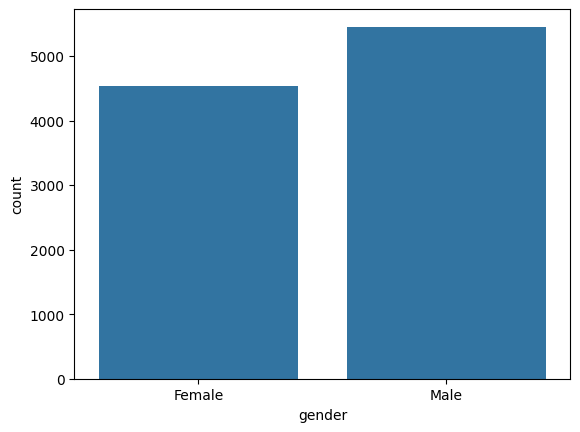




Geography


geography
France     0.501301
Germany    0.251000
Spain      0.247699
Name: proportion, dtype: float64

There are 3 unique values in the column geography which are ['France' 'Spain' 'Germany']


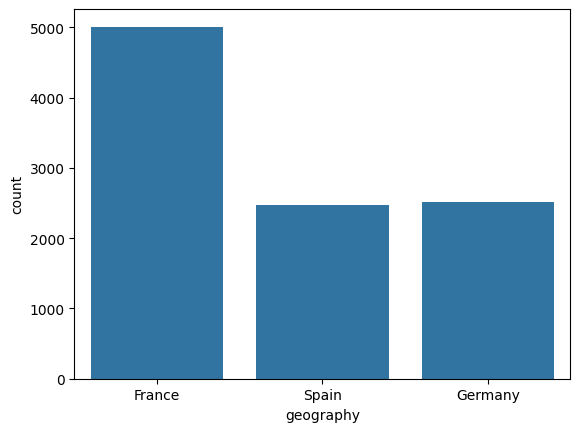

In [40]:
for cat_col in categorical_cols:
    print(f"{cat_col.title()}")
    plots_for_categorical_cols(cat_col)
    print("\n\n")

In [41]:
X

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,iszerobal
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,0
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,1
5,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,1
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,0


In [42]:
# distribution of target

y.value_counts(normalize=True)

exited
0    0.796218
1    0.203782
Name: proportion, dtype: float64

## FE and Model training

In [43]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [44]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=30,stratify=y)

In [45]:
print(f"The shape of training data is {X_train.shape}")
print(f"The shape of test data is {X_test.shape}")

The shape of training data is (7996, 11)
The shape of test data is (2000, 11)


In [46]:
# column transformer

scaler = MinMaxScaler()

encoder = OneHotEncoder(handle_unknown="ignore",sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ("scaler",scaler,numerical_cols),
    ("encoder",encoder,categorical_cols)
], remainder="passthrough",verbose_feature_names_out=False)

In [47]:
preprocessor

,transformers,"[('scaler', ...), ('encoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,feature_range,"(0, ...)"
,copy,True
,clip,False


In [48]:
# apply the transformation

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [49]:
X_train

,creditscore,age,balance,estimatedsalary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain,tenure,numofproducts,hascrcard,isactivemember,iszerobal
5582,0.368,0.270270,0.000000,0.719780,0.0,1.0,1.0,0.0,0.0,3,1,0.0,0.0,1
2549,0.590,0.243243,0.000000,0.060437,1.0,0.0,1.0,0.0,0.0,8,2,1.0,1.0,1
7202,0.446,0.729730,0.393649,0.480118,1.0,0.0,0.0,0.0,1.0,8,1,1.0,1.0,0
2523,0.812,0.081081,0.000000,0.921041,1.0,0.0,1.0,0.0,0.0,1,2,1.0,0.0,1
9655,0.466,0.297297,0.222307,0.134572,1.0,0.0,1.0,0.0,0.0,4,2,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9709,0.450,0.527027,0.549773,0.422404,1.0,0.0,1.0,0.0,0.0,8,1,1.0,1.0,0
4978,0.380,0.229730,0.509378,0.421225,0.0,1.0,0.0,1.0,0.0,7,1,0.0,1.0,0
3618,0.278,0.378378,0.366922,0.736207,1.0,0.0,0.0,1.0,0.0,8,1,1.0,0.0,0
5671,0.786,0.743243,0.000000,0.539389,1.0,0.0,1.0,0.0,0.0,6,2,0.0,1.0,1


In [50]:
X_test

,creditscore,age,balance,estimatedsalary,gender_Female,gender_Male,geography_France,geography_Germany,geography_Spain,tenure,numofproducts,hascrcard,isactivemember,iszerobal
9170,0.688,0.162162,0.000000,0.075154,0.0,1.0,1.0,0.0,0.0,2,3,0.0,1.0,1
5072,0.244,0.148649,0.408494,0.906250,0.0,1.0,1.0,0.0,0.0,8,1,0.0,1.0,0
8108,0.174,0.229730,0.505398,0.805774,0.0,1.0,0.0,1.0,0.0,6,2,1.0,1.0,0
2560,0.600,0.162162,0.000000,0.339997,1.0,0.0,0.0,0.0,1.0,6,1,0.0,0.0,1
5199,0.864,0.121622,0.000000,0.718159,1.0,0.0,0.0,0.0,1.0,3,2,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.392,0.324324,0.554291,0.434756,0.0,1.0,0.0,0.0,1.0,7,1,1.0,1.0,0
455,0.312,0.243243,0.000000,0.821377,0.0,1.0,1.0,0.0,0.0,5,2,1.0,0.0,1
4095,0.760,0.594595,0.447118,0.307574,0.0,1.0,0.0,0.0,1.0,5,1,0.0,1.0,0
1009,0.600,0.716216,0.000000,0.877025,0.0,1.0,0.0,0.0,1.0,0,1,1.0,1.0,1


### Model Building

In [51]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [52]:
from sklearn.ensemble import VotingClassifier

In [53]:
# define models

rf = RandomForestClassifier(class_weight="balanced", random_state=42)

xgb = XGBClassifier(class_weight="balanced", random_state=42)

lgbm = LGBMClassifier(class_weight="balanced", random_state=42)

In [54]:
# build a voting classifier

model = VotingClassifier(estimators=[
    ("rf",rf),
    ("xgb",xgb),
    ("lgbm",lgbm)
], voting="soft",n_jobs=-1)

model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [55]:
# fit the model on the dataset

model.fit(X_train, y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1


In [56]:
# get the predictions

y_pred = model.predict(X_test)

In [57]:
model.predict_proba(X_test.iloc[0:5,:])

array([[0.66581442, 0.33418559],
       [0.95182903, 0.04817097],
       [0.9513067 , 0.04869331],
       [0.73605231, 0.26394769],
       [0.96801903, 0.03198098]])

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1592
           1       0.73      0.58      0.65       408

    accuracy                           0.87      2000
   macro avg       0.82      0.76      0.78      2000
weighted avg       0.86      0.87      0.87      2000



#### HP Tuning

In [73]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [74]:
model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,189
,criterion,'gini'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1


In [75]:
model.estimators

[('rf',
  RandomForestClassifier(class_weight='balanced', max_depth=7,
                         max_samples=0.8947817801601688, n_estimators=189,
                         random_state=42)),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                class_weight='balanced', colsample_bylevel=None,
                colsample_bynode=0.8112448353808821, colsample_bytree=None,
                device=None, early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1465783033902418,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=129, n_jobs=None

In [76]:
def objective(trial: optuna.Trial):
    
    params_dict = {
        "rf__n_estimators": trial.suggest_int("rf__n_estimators", 50, 200),
        "rf__max_depth": trial.suggest_int("rf__max_depth", 5, 12),
        "rf__max_samples": trial.suggest_float("rf__max_samples", 0.5, 1.0),
        "xgb__learning_rate": trial.suggest_float("xgb__learning_rate", 0.01, 0.5),
        "xgb__max_depth": trial.suggest_int("xgb__max_depth", 5, 15),
        "xgb__n_estimators": trial.suggest_int("xgb__n_estimators", 30, 200),
        "xgb__subsample": trial.suggest_float("xgb__subsample", 0.5,1.0),
        "xgb__colsample_bynode": trial.suggest_float("xgb__colsample_bynode", 0.7, 1.0),
        "xgb__reg_lambda": trial.suggest_float("xgb__reg_lambda",0.1,10.0),
        "lgbm__max_depth": trial.suggest_int("lgbm__max_depth", 5, 15),
        "lgbm__n_estimators": trial.suggest_int("lgbm__n_estimators", 30, 200),
        "lgbm__learning_rate": trial.suggest_float("lgbm__learning_rate", 0.01, 0.5),
        "lgbm__subsample": trial.suggest_float("lgbm__subsample", 0.5,1.0),
        "lgbm__reg_lambda": trial.suggest_float("lgbm__reg_lambda",0.1,10.0)
    }
    
    # define models
    rf = RandomForestClassifier(class_weight="balanced", random_state=42)
    xgb = XGBClassifier(class_weight="balanced", random_state=42)
    lgbm = LGBMClassifier(class_weight="balanced", random_state=42)
    
    # build a voting classifier
    model = VotingClassifier(estimators=[
        ("rf",rf),
        ("xgb",xgb),
        ("lgbm",lgbm)
    ], voting="soft",n_jobs=-1)
    
    # pass parameters to model
    model.set_params(**params_dict)
    
    # cross validation
    scores = cross_val_score(estimator=model,
                             X=X_train, y=y_train,
                             scoring="f1", 
                             cv=StratifiedKFold(n_splits=5,random_state=10,shuffle=True),
                             n_jobs=-1)
    
    # mean f1
    mean_f1 = np.mean(scores)
    
    return mean_f1

In [77]:
# define my study

study = optuna.create_study(direction="maximize")

study.optimize(func=objective,n_trials=100,n_jobs=-1,show_progress_bar=True)

[I 2025-09-11 20:09:35,751] A new study created in memory with name: no-name-3c1f10c2-c087-4b97-9b72-4cb765fcf8e0
Best trial: 1. Best value: 0.599485:   1%|          | 1/100 [00:50<1:22:49, 50.19s/it]

[I 2025-09-11 20:10:25,931] Trial 1 finished with value: 0.5994848380991467 and parameters: {'rf__n_estimators': 156, 'rf__max_depth': 12, 'rf__max_samples': 0.5850324959930092, 'xgb__learning_rate': 0.2739994801235551, 'xgb__max_depth': 10, 'xgb__n_estimators': 155, 'xgb__subsample': 0.5821905907253075, 'xgb__colsample_bynode': 0.8870642959344484, 'xgb__reg_lambda': 0.43201070698958277, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 41, 'lgbm__learning_rate': 0.21031118164978066, 'lgbm__subsample': 0.7772892156010519, 'lgbm__reg_lambda': 0.5353402011182766}. Best is trial 1 with value: 0.5994848380991467.


Best trial: 2. Best value: 0.599627:   2%|▏         | 2/100 [00:55<39:14, 24.03s/it]  

[I 2025-09-11 20:10:31,649] Trial 2 finished with value: 0.5996265419776645 and parameters: {'rf__n_estimators': 59, 'rf__max_depth': 7, 'rf__max_samples': 0.7090229274719311, 'xgb__learning_rate': 0.32967871311753466, 'xgb__max_depth': 13, 'xgb__n_estimators': 169, 'xgb__subsample': 0.5765847374102044, 'xgb__colsample_bynode': 0.8030905319386719, 'xgb__reg_lambda': 4.522385372466764, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 195, 'lgbm__learning_rate': 0.12392390662953942, 'lgbm__subsample': 0.6266627743271617, 'lgbm__reg_lambda': 3.2381207283672153}. Best is trial 2 with value: 0.5996265419776645.


Best trial: 2. Best value: 0.599627:   3%|▎         | 3/100 [00:58<23:03, 14.26s/it]

[I 2025-09-11 20:10:34,283] Trial 0 finished with value: 0.5935818531451686 and parameters: {'rf__n_estimators': 134, 'rf__max_depth': 12, 'rf__max_samples': 0.8873060982247816, 'xgb__learning_rate': 0.45910052869856516, 'xgb__max_depth': 12, 'xgb__n_estimators': 192, 'xgb__subsample': 0.8526167080494879, 'xgb__colsample_bynode': 0.8492575883749458, 'xgb__reg_lambda': 4.140685402391616, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 118, 'lgbm__learning_rate': 0.19951901375021602, 'lgbm__subsample': 0.5526434290359836, 'lgbm__reg_lambda': 0.4674640278285277}. Best is trial 2 with value: 0.5996265419776645.


Best trial: 3. Best value: 0.606562:   4%|▍         | 4/100 [01:02<16:32, 10.34s/it]

[I 2025-09-11 20:10:38,612] Trial 3 finished with value: 0.6065620868166922 and parameters: {'rf__n_estimators': 102, 'rf__max_depth': 9, 'rf__max_samples': 0.8665648581648575, 'xgb__learning_rate': 0.3830585127934758, 'xgb__max_depth': 14, 'xgb__n_estimators': 135, 'xgb__subsample': 0.6102119838919289, 'xgb__colsample_bynode': 0.8167440262474595, 'xgb__reg_lambda': 9.384059167897755, 'lgbm__max_depth': 14, 'lgbm__n_estimators': 100, 'lgbm__learning_rate': 0.07298267221402736, 'lgbm__subsample': 0.5427175294567165, 'lgbm__reg_lambda': 3.698890581555331}. Best is trial 3 with value: 0.6065620868166922.


Best trial: 4. Best value: 0.613621:   5%|▌         | 5/100 [01:08<13:37,  8.60s/it]

[I 2025-09-11 20:10:44,139] Trial 4 finished with value: 0.6136205864834156 and parameters: {'rf__n_estimators': 65, 'rf__max_depth': 7, 'rf__max_samples': 0.6344429690281914, 'xgb__learning_rate': 0.08152893234350472, 'xgb__max_depth': 6, 'xgb__n_estimators': 80, 'xgb__subsample': 0.6601445398271024, 'xgb__colsample_bynode': 0.9507840326872132, 'xgb__reg_lambda': 9.933402132264057, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 155, 'lgbm__learning_rate': 0.32251819165859485, 'lgbm__subsample': 0.8882947962012613, 'lgbm__reg_lambda': 8.281194847010322}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:   6%|▌         | 6/100 [01:13<11:25,  7.29s/it]

[I 2025-09-11 20:10:48,888] Trial 5 finished with value: 0.6024272349372206 and parameters: {'rf__n_estimators': 156, 'rf__max_depth': 12, 'rf__max_samples': 0.8972086846423317, 'xgb__learning_rate': 0.4576526166348407, 'xgb__max_depth': 8, 'xgb__n_estimators': 36, 'xgb__subsample': 0.6156865666205, 'xgb__colsample_bynode': 0.887752334951819, 'xgb__reg_lambda': 0.6707629349895645, 'lgbm__max_depth': 14, 'lgbm__n_estimators': 44, 'lgbm__learning_rate': 0.2348229593122402, 'lgbm__subsample': 0.6086518254275836, 'lgbm__reg_lambda': 8.016667537346873}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:   7%|▋         | 7/100 [01:16<09:29,  6.12s/it]

[I 2025-09-11 20:10:52,588] Trial 6 finished with value: 0.6076221446154723 and parameters: {'rf__n_estimators': 161, 'rf__max_depth': 10, 'rf__max_samples': 0.6708825261399516, 'xgb__learning_rate': 0.4239614776726918, 'xgb__max_depth': 6, 'xgb__n_estimators': 40, 'xgb__subsample': 0.726383468361175, 'xgb__colsample_bynode': 0.9954694663012207, 'xgb__reg_lambda': 3.849057327519984, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 81, 'lgbm__learning_rate': 0.3102763498640012, 'lgbm__subsample': 0.9416510551355524, 'lgbm__reg_lambda': 6.136765195090863}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:   8%|▊         | 8/100 [01:19<07:51,  5.13s/it]

[I 2025-09-11 20:10:55,584] Trial 7 finished with value: 0.611497195557123 and parameters: {'rf__n_estimators': 66, 'rf__max_depth': 6, 'rf__max_samples': 0.778988178433597, 'xgb__learning_rate': 0.065706151277129, 'xgb__max_depth': 10, 'xgb__n_estimators': 99, 'xgb__subsample': 0.7228482459893097, 'xgb__colsample_bynode': 0.7543016380083029, 'xgb__reg_lambda': 0.35401992225304946, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 89, 'lgbm__learning_rate': 0.1463062788071311, 'lgbm__subsample': 0.8056240098559739, 'lgbm__reg_lambda': 1.590780818027112}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:   9%|▉         | 9/100 [01:28<09:31,  6.28s/it]

[I 2025-09-11 20:11:04,403] Trial 8 finished with value: 0.5932546118678987 and parameters: {'rf__n_estimators': 141, 'rf__max_depth': 5, 'rf__max_samples': 0.8330171563442184, 'xgb__learning_rate': 0.2866649691389936, 'xgb__max_depth': 7, 'xgb__n_estimators': 140, 'xgb__subsample': 0.6847406883859728, 'xgb__colsample_bynode': 0.8638356400134095, 'xgb__reg_lambda': 1.1288980664783128, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 83, 'lgbm__learning_rate': 0.46954746734943786, 'lgbm__subsample': 0.7065480430527467, 'lgbm__reg_lambda': 6.287801291026721}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:  10%|█         | 10/100 [01:33<08:36,  5.74s/it]

[I 2025-09-11 20:11:08,937] Trial 9 finished with value: 0.6041544355464967 and parameters: {'rf__n_estimators': 186, 'rf__max_depth': 8, 'rf__max_samples': 0.600852830870354, 'xgb__learning_rate': 0.3601367488520865, 'xgb__max_depth': 15, 'xgb__n_estimators': 192, 'xgb__subsample': 0.7122516002144172, 'xgb__colsample_bynode': 0.9924090960508953, 'xgb__reg_lambda': 4.6084498090213275, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 76, 'lgbm__learning_rate': 0.10664385793195455, 'lgbm__subsample': 0.8560175754842152, 'lgbm__reg_lambda': 5.164161381244591}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:  11%|█         | 11/100 [01:39<08:42,  5.87s/it]

[I 2025-09-11 20:11:15,117] Trial 10 finished with value: 0.5980965891452764 and parameters: {'rf__n_estimators': 50, 'rf__max_depth': 11, 'rf__max_samples': 0.5987421027073905, 'xgb__learning_rate': 0.34832451756169003, 'xgb__max_depth': 5, 'xgb__n_estimators': 182, 'xgb__subsample': 0.6032711262958679, 'xgb__colsample_bynode': 0.7887615801272003, 'xgb__reg_lambda': 9.572854037854754, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 164, 'lgbm__learning_rate': 0.3192770888203261, 'lgbm__subsample': 0.5134281840935033, 'lgbm__reg_lambda': 1.9315048839353908}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:  12%|█▏        | 12/100 [01:45<08:31,  5.81s/it]

[I 2025-09-11 20:11:20,763] Trial 11 finished with value: 0.5935474079614559 and parameters: {'rf__n_estimators': 56, 'rf__max_depth': 7, 'rf__max_samples': 0.8728411339194924, 'xgb__learning_rate': 0.04865065650546428, 'xgb__max_depth': 12, 'xgb__n_estimators': 198, 'xgb__subsample': 0.803336488035318, 'xgb__colsample_bynode': 0.8582229610612347, 'xgb__reg_lambda': 9.69916780928284, 'lgbm__max_depth': 13, 'lgbm__n_estimators': 189, 'lgbm__learning_rate': 0.4395262612690615, 'lgbm__subsample': 0.9862614427072547, 'lgbm__reg_lambda': 1.6889137946109698}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:  13%|█▎        | 13/100 [01:49<07:58,  5.50s/it]

[I 2025-09-11 20:11:25,549] Trial 12 finished with value: 0.5971115635439919 and parameters: {'rf__n_estimators': 145, 'rf__max_depth': 10, 'rf__max_samples': 0.8782306110635333, 'xgb__learning_rate': 0.40418754617679176, 'xgb__max_depth': 6, 'xgb__n_estimators': 72, 'xgb__subsample': 0.6017052065696149, 'xgb__colsample_bynode': 0.8768585027616349, 'xgb__reg_lambda': 4.184069092381926, 'lgbm__max_depth': 15, 'lgbm__n_estimators': 134, 'lgbm__learning_rate': 0.4827296102382952, 'lgbm__subsample': 0.861852781794541, 'lgbm__reg_lambda': 8.819807197516417}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:  14%|█▍        | 14/100 [01:52<06:32,  4.56s/it]

[I 2025-09-11 20:11:27,921] Trial 13 finished with value: 0.6121391791239581 and parameters: {'rf__n_estimators': 96, 'rf__max_depth': 5, 'rf__max_samples': 0.9985177934609106, 'xgb__learning_rate': 0.09802888892278586, 'xgb__max_depth': 5, 'xgb__n_estimators': 91, 'xgb__subsample': 0.9548938182853657, 'xgb__colsample_bynode': 0.9367807415843707, 'xgb__reg_lambda': 9.929427206319223, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 157, 'lgbm__learning_rate': 0.3560793464204038, 'lgbm__subsample': 0.9834462959354071, 'lgbm__reg_lambda': 9.15713565894253}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 4. Best value: 0.613621:  15%|█▌        | 15/100 [01:58<07:18,  5.15s/it]

[I 2025-09-11 20:11:34,480] Trial 14 finished with value: 0.6071300443570864 and parameters: {'rf__n_estimators': 90, 'rf__max_depth': 6, 'rf__max_samples': 0.7795227190360334, 'xgb__learning_rate': 0.05616386120284636, 'xgb__max_depth': 10, 'xgb__n_estimators': 85, 'xgb__subsample': 0.837824675014188, 'xgb__colsample_bynode': 0.7109114935705771, 'xgb__reg_lambda': 6.725179743119305, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 144, 'lgbm__learning_rate': 0.41762266046244806, 'lgbm__subsample': 0.984817072472723, 'lgbm__reg_lambda': 9.877903952907761}. Best is trial 4 with value: 0.6136205864834156.


Best trial: 15. Best value: 0.61485:  16%|█▌        | 16/100 [02:02<06:37,  4.73s/it]

[I 2025-09-11 20:11:38,212] Trial 15 finished with value: 0.6148501198745936 and parameters: {'rf__n_estimators': 94, 'rf__max_depth': 5, 'rf__max_samples': 0.5040240095884727, 'xgb__learning_rate': 0.07673282055844974, 'xgb__max_depth': 9, 'xgb__n_estimators': 86, 'xgb__subsample': 0.9087965074703922, 'xgb__colsample_bynode': 0.7219462025398851, 'xgb__reg_lambda': 7.264105215518902, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 139, 'lgbm__learning_rate': 0.011685880426652528, 'lgbm__subsample': 0.8654574233317919, 'lgbm__reg_lambda': 9.30753413442302}. Best is trial 15 with value: 0.6148501198745936.


Best trial: 15. Best value: 0.61485:  17%|█▋        | 17/100 [02:06<06:14,  4.51s/it]

[I 2025-09-11 20:11:42,222] Trial 16 finished with value: 0.6047927390219107 and parameters: {'rf__n_estimators': 94, 'rf__max_depth': 5, 'rf__max_samples': 0.7787690128982065, 'xgb__learning_rate': 0.06974790025963819, 'xgb__max_depth': 9, 'xgb__n_estimators': 93, 'xgb__subsample': 0.9579064942580675, 'xgb__colsample_bynode': 0.7167648126107582, 'xgb__reg_lambda': 7.659815665868094, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 149, 'lgbm__learning_rate': 0.3563577794126449, 'lgbm__subsample': 0.816374661028555, 'lgbm__reg_lambda': 7.308763581512456}. Best is trial 15 with value: 0.6148501198745936.


Best trial: 15. Best value: 0.61485:  18%|█▊        | 18/100 [02:11<06:11,  4.54s/it]

[I 2025-09-11 20:11:46,818] Trial 17 finished with value: 0.610462082351346 and parameters: {'rf__n_estimators': 97, 'rf__max_depth': 5, 'rf__max_samples': 0.9688057533766835, 'xgb__learning_rate': 0.154849768133313, 'xgb__max_depth': 8, 'xgb__n_estimators': 91, 'xgb__subsample': 0.9502739599785673, 'xgb__colsample_bynode': 0.9360805897539305, 'xgb__reg_lambda': 7.597103914551395, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 158, 'lgbm__learning_rate': 0.37759678043120387, 'lgbm__subsample': 0.9309622835943161, 'lgbm__reg_lambda': 9.815648413424716}. Best is trial 15 with value: 0.6148501198745936.


Best trial: 15. Best value: 0.61485:  19%|█▉        | 19/100 [02:15<06:02,  4.48s/it]

[I 2025-09-11 20:11:51,164] Trial 18 finished with value: 0.6054192747455645 and parameters: {'rf__n_estimators': 108, 'rf__max_depth': 5, 'rf__max_samples': 0.98258915191297, 'xgb__learning_rate': 0.16169357975480395, 'xgb__max_depth': 8, 'xgb__n_estimators': 62, 'xgb__subsample': 0.9939107816629761, 'xgb__colsample_bynode': 0.9396954881706415, 'xgb__reg_lambda': 7.63645553695003, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 168, 'lgbm__learning_rate': 0.3520956457103537, 'lgbm__subsample': 0.9038802035112665, 'lgbm__reg_lambda': 7.6832903022473715}. Best is trial 15 with value: 0.6148501198745936.


Best trial: 15. Best value: 0.61485:  20%|██        | 20/100 [02:20<06:01,  4.52s/it]

[I 2025-09-11 20:11:55,793] Trial 19 finished with value: 0.6141070983771753 and parameters: {'rf__n_estimators': 113, 'rf__max_depth': 7, 'rf__max_samples': 0.5052580554890339, 'xgb__learning_rate': 0.16018673826841454, 'xgb__max_depth': 8, 'xgb__n_estimators': 59, 'xgb__subsample': 0.9891634086414263, 'xgb__colsample_bynode': 0.9374577887865653, 'xgb__reg_lambda': 7.828297740169438, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 173, 'lgbm__learning_rate': 0.025324684692791116, 'lgbm__subsample': 0.8915351907106077, 'lgbm__reg_lambda': 7.392263689475964}. Best is trial 15 with value: 0.6148501198745936.


Best trial: 20. Best value: 0.615789:  21%|██        | 21/100 [02:23<05:23,  4.10s/it]

[I 2025-09-11 20:11:58,899] Trial 20 finished with value: 0.6157889651971687 and parameters: {'rf__n_estimators': 113, 'rf__max_depth': 7, 'rf__max_samples': 0.5140958516176658, 'xgb__learning_rate': 0.17563220734813673, 'xgb__max_depth': 8, 'xgb__n_estimators': 60, 'xgb__subsample': 0.5007157136720679, 'xgb__colsample_bynode': 0.9354622518533886, 'xgb__reg_lambda': 7.819593588577621, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 177, 'lgbm__learning_rate': 0.01885200907886849, 'lgbm__subsample': 0.901763439805618, 'lgbm__reg_lambda': 7.3631380141646865}. Best is trial 20 with value: 0.6157889651971687.


Best trial: 20. Best value: 0.615789:  22%|██▏       | 22/100 [02:31<06:52,  5.29s/it]

[I 2025-09-11 20:12:06,980] Trial 21 finished with value: 0.6133442761135822 and parameters: {'rf__n_estimators': 75, 'rf__max_depth': 7, 'rf__max_samples': 0.5028623648125562, 'xgb__learning_rate': 0.17913181465014877, 'xgb__max_depth': 8, 'xgb__n_estimators': 61, 'xgb__subsample': 0.5050975629519432, 'xgb__colsample_bynode': 0.9480170989267859, 'xgb__reg_lambda': 6.111726557178142, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 178, 'lgbm__learning_rate': 0.04065512077579171, 'lgbm__subsample': 0.707846256600348, 'lgbm__reg_lambda': 7.4534731169563635}. Best is trial 20 with value: 0.6157889651971687.


Best trial: 22. Best value: 0.61588:  23%|██▎       | 23/100 [02:32<05:25,  4.23s/it] 

[I 2025-09-11 20:12:08,733] Trial 22 finished with value: 0.6158803000670885 and parameters: {'rf__n_estimators': 76, 'rf__max_depth': 7, 'rf__max_samples': 0.5265717776857942, 'xgb__learning_rate': 0.19539204308664496, 'xgb__max_depth': 11, 'xgb__n_estimators': 111, 'xgb__subsample': 0.8908598134743049, 'xgb__colsample_bynode': 0.7570071738657197, 'xgb__reg_lambda': 5.876369568760145, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 122, 'lgbm__learning_rate': 0.02790990084351669, 'lgbm__subsample': 0.7169887237457782, 'lgbm__reg_lambda': 6.679198344622179}. Best is trial 22 with value: 0.6158803000670885.


Best trial: 22. Best value: 0.61588:  24%|██▍       | 24/100 [02:36<05:10,  4.09s/it]

[I 2025-09-11 20:12:12,487] Trial 23 finished with value: 0.6077109495701766 and parameters: {'rf__n_estimators': 119, 'rf__max_depth': 8, 'rf__max_samples': 0.514761114467706, 'xgb__learning_rate': 0.2005918115387006, 'xgb__max_depth': 11, 'xgb__n_estimators': 117, 'xgb__subsample': 0.897603291312433, 'xgb__colsample_bynode': 0.7596013667083343, 'xgb__reg_lambda': 5.899051829415231, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 122, 'lgbm__learning_rate': 0.010724022774908769, 'lgbm__subsample': 0.7253186691646911, 'lgbm__reg_lambda': 6.798053469608711}. Best is trial 22 with value: 0.6158803000670885.


Best trial: 22. Best value: 0.61588:  25%|██▌       | 25/100 [02:46<07:14,  5.80s/it]

[I 2025-09-11 20:12:22,282] Trial 24 finished with value: 0.6146142552370675 and parameters: {'rf__n_estimators': 118, 'rf__max_depth': 8, 'rf__max_samples': 0.5008269171823274, 'xgb__learning_rate': 0.20273363252391025, 'xgb__max_depth': 9, 'xgb__n_estimators': 56, 'xgb__subsample': 0.9150791311529053, 'xgb__colsample_bynode': 0.9084550692715276, 'xgb__reg_lambda': 6.100632746754745, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 179, 'lgbm__learning_rate': 0.03238958224857121, 'lgbm__subsample': 0.7531019167649837, 'lgbm__reg_lambda': 6.6909210228746785}. Best is trial 22 with value: 0.6158803000670885.


Best trial: 22. Best value: 0.61588:  26%|██▌       | 26/100 [02:48<05:48,  4.72s/it]

[I 2025-09-11 20:12:24,462] Trial 25 finished with value: 0.6128514022135664 and parameters: {'rf__n_estimators': 119, 'rf__max_depth': 8, 'rf__max_samples': 0.500218505819589, 'xgb__learning_rate': 0.1988085250348398, 'xgb__max_depth': 9, 'xgb__n_estimators': 115, 'xgb__subsample': 0.8751813111815838, 'xgb__colsample_bynode': 0.9146874721388467, 'xgb__reg_lambda': 8.513819575716662, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 125, 'lgbm__learning_rate': 0.021015288253407354, 'lgbm__subsample': 0.8332633192689475, 'lgbm__reg_lambda': 6.284554994456787}. Best is trial 22 with value: 0.6158803000670885.


Best trial: 22. Best value: 0.61588:  27%|██▋       | 27/100 [02:54<06:02,  4.96s/it]

[I 2025-09-11 20:12:30,012] Trial 26 finished with value: 0.6097729005771357 and parameters: {'rf__n_estimators': 78, 'rf__max_depth': 8, 'rf__max_samples': 0.5487556022268318, 'xgb__learning_rate': 0.22796782112116543, 'xgb__max_depth': 11, 'xgb__n_estimators': 118, 'xgb__subsample': 0.9030714713197031, 'xgb__colsample_bynode': 0.748667518711335, 'xgb__reg_lambda': 5.7806878785871785, 'lgbm__max_depth': 9, 'lgbm__n_estimators': 125, 'lgbm__learning_rate': 0.019863317097337657, 'lgbm__subsample': 0.7103825135112279, 'lgbm__reg_lambda': 6.26998720931953}. Best is trial 22 with value: 0.6158803000670885.


Best trial: 22. Best value: 0.61588:  28%|██▊       | 28/100 [02:58<05:37,  4.68s/it]

[I 2025-09-11 20:12:34,033] Trial 27 finished with value: 0.6094378671747056 and parameters: {'rf__n_estimators': 76, 'rf__max_depth': 6, 'rf__max_samples': 0.5639629548203594, 'xgb__learning_rate': 0.22685801478681572, 'xgb__max_depth': 11, 'xgb__n_estimators': 119, 'xgb__subsample': 0.8920473905941669, 'xgb__colsample_bynode': 0.7466002681845926, 'xgb__reg_lambda': 2.9297171744261044, 'lgbm__max_depth': 8, 'lgbm__n_estimators': 136, 'lgbm__learning_rate': 0.07666007514958219, 'lgbm__subsample': 0.6575509731253347, 'lgbm__reg_lambda': 5.533011949570925}. Best is trial 22 with value: 0.6158803000670885.


Best trial: 22. Best value: 0.61588:  29%|██▉       | 29/100 [03:03<05:52,  4.96s/it]

[I 2025-09-11 20:12:39,644] Trial 28 finished with value: 0.6151988923351396 and parameters: {'rf__n_estimators': 80, 'rf__max_depth': 6, 'rf__max_samples': 0.5522454840298885, 'xgb__learning_rate': 0.1176706928106572, 'xgb__max_depth': 11, 'xgb__n_estimators': 119, 'xgb__subsample': 0.7808301924325474, 'xgb__colsample_bynode': 0.7458421854841182, 'xgb__reg_lambda': 8.696455061711992, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 132, 'lgbm__learning_rate': 0.06870426679442715, 'lgbm__subsample': 0.6660017551141881, 'lgbm__reg_lambda': 5.143560516566247}. Best is trial 22 with value: 0.6158803000670885.


Best trial: 29. Best value: 0.616161:  30%|███       | 30/100 [03:08<05:31,  4.73s/it]

[I 2025-09-11 20:12:43,852] Trial 29 finished with value: 0.6161612145519358 and parameters: {'rf__n_estimators': 89, 'rf__max_depth': 6, 'rf__max_samples': 0.5611913585356019, 'xgb__learning_rate': 0.012845127865855704, 'xgb__max_depth': 11, 'xgb__n_estimators': 107, 'xgb__subsample': 0.802030144092592, 'xgb__colsample_bynode': 0.73995772550172, 'xgb__reg_lambda': 2.8992273848854806, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 140, 'lgbm__learning_rate': 0.08662853208189297, 'lgbm__subsample': 0.6561438651068203, 'lgbm__reg_lambda': 5.287580411390849}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  31%|███       | 31/100 [03:13<05:35,  4.86s/it]

[I 2025-09-11 20:12:48,995] Trial 30 finished with value: 0.612968770067114 and parameters: {'rf__n_estimators': 79, 'rf__max_depth': 6, 'rf__max_samples': 0.558409783521405, 'xgb__learning_rate': 0.10849695020458196, 'xgb__max_depth': 12, 'xgb__n_estimators': 105, 'xgb__subsample': 0.7843467101874774, 'xgb__colsample_bynode': 0.7308078403313298, 'xgb__reg_lambda': 6.909304511937077, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 102, 'lgbm__learning_rate': 0.0817435415093574, 'lgbm__subsample': 0.6503442197598531, 'lgbm__reg_lambda': 5.308280161936693}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  32%|███▏      | 32/100 [03:16<04:49,  4.26s/it]

[I 2025-09-11 20:12:51,862] Trial 31 finished with value: 0.6140103943940275 and parameters: {'rf__n_estimators': 86, 'rf__max_depth': 6, 'rf__max_samples': 0.644407421029906, 'xgb__learning_rate': 0.018384395920462454, 'xgb__max_depth': 7, 'xgb__n_estimators': 46, 'xgb__subsample': 0.8237781562891068, 'xgb__colsample_bynode': 0.8335530727616349, 'xgb__reg_lambda': 6.741464508953908, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 101, 'lgbm__learning_rate': 0.15051969901163104, 'lgbm__subsample': 0.7818128105574467, 'lgbm__reg_lambda': 8.82134027103404}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  33%|███▎      | 33/100 [03:20<04:52,  4.37s/it]

[I 2025-09-11 20:12:56,496] Trial 32 finished with value: 0.6093052287449792 and parameters: {'rf__n_estimators': 87, 'rf__max_depth': 6, 'rf__max_samples': 0.6270859584180798, 'xgb__learning_rate': 0.11947111007071723, 'xgb__max_depth': 12, 'xgb__n_estimators': 144, 'xgb__subsample': 0.7871881689219349, 'xgb__colsample_bynode': 0.8340026022174402, 'xgb__reg_lambda': 8.612643730038549, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 111, 'lgbm__learning_rate': 0.1634168416010034, 'lgbm__subsample': 0.6596944831507132, 'lgbm__reg_lambda': 3.9687728495709864}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  34%|███▍      | 34/100 [03:30<06:29,  5.90s/it]

[I 2025-09-11 20:13:05,976] Trial 33 finished with value: 0.6088044353773514 and parameters: {'rf__n_estimators': 134, 'rf__max_depth': 9, 'rf__max_samples': 0.6402901472920463, 'xgb__learning_rate': 0.024698673330413007, 'xgb__max_depth': 12, 'xgb__n_estimators': 137, 'xgb__subsample': 0.8250083883590416, 'xgb__colsample_bynode': 0.8307132747788071, 'xgb__reg_lambda': 2.2174006436410147, 'lgbm__max_depth': 8, 'lgbm__n_estimators': 110, 'lgbm__learning_rate': 0.1581837639125983, 'lgbm__subsample': 0.585936191411929, 'lgbm__reg_lambda': 4.043250722220159}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  35%|███▌      | 35/100 [03:37<06:56,  6.41s/it]

[I 2025-09-11 20:13:13,560] Trial 34 finished with value: 0.6132767307515199 and parameters: {'rf__n_estimators': 129, 'rf__max_depth': 6, 'rf__max_samples': 0.6222412539857819, 'xgb__learning_rate': 0.1244419182836024, 'xgb__max_depth': 13, 'xgb__n_estimators': 135, 'xgb__subsample': 0.7789079693935905, 'xgb__colsample_bynode': 0.7830138370671373, 'xgb__reg_lambda': 2.239052179142406, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 115, 'lgbm__learning_rate': 0.14798589787147537, 'lgbm__subsample': 0.5908526590927996, 'lgbm__reg_lambda': 4.374861194853701}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  36%|███▌      | 36/100 [03:42<06:24,  6.01s/it]

[I 2025-09-11 20:13:18,638] Trial 35 finished with value: 0.6061714756813965 and parameters: {'rf__n_estimators': 131, 'rf__max_depth': 6, 'rf__max_samples': 0.5449872485304351, 'xgb__learning_rate': 0.12370426576100245, 'xgb__max_depth': 13, 'xgb__n_estimators': 145, 'xgb__subsample': 0.7628280255330423, 'xgb__colsample_bynode': 0.7831646887875661, 'xgb__reg_lambda': 2.344026737077905, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 111, 'lgbm__learning_rate': 0.1638351836410103, 'lgbm__subsample': 0.5884007757653338, 'lgbm__reg_lambda': 4.225673912742691}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  37%|███▋      | 37/100 [03:48<06:06,  5.82s/it]

[I 2025-09-11 20:13:24,019] Trial 36 finished with value: 0.6151676815182784 and parameters: {'rf__n_estimators': 130, 'rf__max_depth': 7, 'rf__max_samples': 0.5341094813501881, 'xgb__learning_rate': 0.01947508492591557, 'xgb__max_depth': 11, 'xgb__n_estimators': 131, 'xgb__subsample': 0.8605769998540125, 'xgb__colsample_bynode': 0.787993255160461, 'xgb__reg_lambda': 2.859512716823069, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 63, 'lgbm__learning_rate': 0.05322038202055382, 'lgbm__subsample': 0.5956347429973222, 'lgbm__reg_lambda': 4.489710924991739}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  38%|███▊      | 38/100 [03:52<05:34,  5.39s/it]

[I 2025-09-11 20:13:28,390] Trial 37 finished with value: 0.6135108965061846 and parameters: {'rf__n_estimators': 106, 'rf__max_depth': 7, 'rf__max_samples': 0.5396074039188563, 'xgb__learning_rate': 0.1320360578975845, 'xgb__max_depth': 13, 'xgb__n_estimators': 151, 'xgb__subsample': 0.7651961362386995, 'xgb__colsample_bynode': 0.7835804853309676, 'xgb__reg_lambda': 8.65467098225309, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 62, 'lgbm__learning_rate': 0.07060534991834765, 'lgbm__subsample': 0.6818001547952852, 'lgbm__reg_lambda': 4.587894678981446}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  39%|███▉      | 39/100 [04:00<06:15,  6.16s/it]

[I 2025-09-11 20:13:36,348] Trial 38 finished with value: 0.6080912095865297 and parameters: {'rf__n_estimators': 107, 'rf__max_depth': 7, 'rf__max_samples': 0.5463191350391384, 'xgb__learning_rate': 0.2884438763940788, 'xgb__max_depth': 13, 'xgb__n_estimators': 149, 'xgb__subsample': 0.7594544339625539, 'xgb__colsample_bynode': 0.7755707227305355, 'xgb__reg_lambda': 5.1895739100141824, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 193, 'lgbm__learning_rate': 0.06162462083738807, 'lgbm__subsample': 0.6841272880703008, 'lgbm__reg_lambda': 4.675098373301508}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  40%|████      | 40/100 [04:05<05:51,  5.87s/it]

[I 2025-09-11 20:13:41,527] Trial 39 finished with value: 0.6070781080743082 and parameters: {'rf__n_estimators': 105, 'rf__max_depth': 7, 'rf__max_samples': 0.6938171863620176, 'xgb__learning_rate': 0.23402287347124023, 'xgb__max_depth': 11, 'xgb__n_estimators': 155, 'xgb__subsample': 0.5539462122134542, 'xgb__colsample_bynode': 0.7704379076731515, 'xgb__reg_lambda': 8.753679867697915, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 199, 'lgbm__learning_rate': 0.0564713682042766, 'lgbm__subsample': 0.6805139986164914, 'lgbm__reg_lambda': 2.989301020556208}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  41%|████      | 41/100 [04:12<05:54,  6.01s/it]

[I 2025-09-11 20:13:47,861] Trial 40 finished with value: 0.6039182833333083 and parameters: {'rf__n_estimators': 106, 'rf__max_depth': 7, 'rf__max_samples': 0.7144298642811501, 'xgb__learning_rate': 0.29338953298349557, 'xgb__max_depth': 10, 'xgb__n_estimators': 164, 'xgb__subsample': 0.510942052908055, 'xgb__colsample_bynode': 0.7655992719158743, 'xgb__reg_lambda': 8.592073554722871, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 144, 'lgbm__learning_rate': 0.10234645838156688, 'lgbm__subsample': 0.680593413413339, 'lgbm__reg_lambda': 5.804586372263712}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  42%|████▏     | 42/100 [04:17<05:40,  5.88s/it]

[I 2025-09-11 20:13:53,441] Trial 41 finished with value: 0.6072427205382435 and parameters: {'rf__n_estimators': 63, 'rf__max_depth': 9, 'rf__max_samples': 0.6984196065409791, 'xgb__learning_rate': 0.29914276589874544, 'xgb__max_depth': 10, 'xgb__n_estimators': 159, 'xgb__subsample': 0.5138412805178971, 'xgb__colsample_bynode': 0.7350020171568866, 'xgb__reg_lambda': 5.486347034785301, 'lgbm__max_depth': 12, 'lgbm__n_estimators': 185, 'lgbm__learning_rate': 0.11072778007465217, 'lgbm__subsample': 0.7650512947296362, 'lgbm__reg_lambda': 3.0187399468436835}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  43%|████▎     | 43/100 [04:23<05:33,  5.85s/it]

[I 2025-09-11 20:13:59,237] Trial 42 finished with value: 0.6033133142860869 and parameters: {'rf__n_estimators': 64, 'rf__max_depth': 9, 'rf__max_samples': 0.692146358887536, 'xgb__learning_rate': 0.22636888668896632, 'xgb__max_depth': 10, 'xgb__n_estimators': 167, 'xgb__subsample': 0.6803246485049264, 'xgb__colsample_bynode': 0.8023522683473959, 'xgb__reg_lambda': 3.5356659492655265, 'lgbm__max_depth': 8, 'lgbm__n_estimators': 130, 'lgbm__learning_rate': 0.19993941920259936, 'lgbm__subsample': 0.7519308545484087, 'lgbm__reg_lambda': 5.6718953126839535}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  44%|████▍     | 44/100 [04:30<05:45,  6.17s/it]

[I 2025-09-11 20:14:06,134] Trial 43 finished with value: 0.6038984442362834 and parameters: {'rf__n_estimators': 68, 'rf__max_depth': 9, 'rf__max_samples': 0.5752127290554804, 'xgb__learning_rate': 0.26336832771419094, 'xgb__max_depth': 10, 'xgb__n_estimators': 168, 'xgb__subsample': 0.6740005588230009, 'xgb__colsample_bynode': 0.8062502761233633, 'xgb__reg_lambda': 5.106797484085485, 'lgbm__max_depth': 8, 'lgbm__n_estimators': 131, 'lgbm__learning_rate': 0.10440527975116183, 'lgbm__subsample': 0.6199758898162728, 'lgbm__reg_lambda': 5.600614439921004}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  45%|████▌     | 45/100 [04:32<04:30,  4.91s/it]

[I 2025-09-11 20:14:08,123] Trial 44 finished with value: 0.6126442421877127 and parameters: {'rf__n_estimators': 65, 'rf__max_depth': 9, 'rf__max_samples': 0.5836052179820946, 'xgb__learning_rate': 0.011504119089806373, 'xgb__max_depth': 10, 'xgb__n_estimators': 112, 'xgb__subsample': 0.8609489686794727, 'xgb__colsample_bynode': 0.80283610956566, 'xgb__reg_lambda': 2.884325533084389, 'lgbm__max_depth': 8, 'lgbm__n_estimators': 52, 'lgbm__learning_rate': 0.19280429441628721, 'lgbm__subsample': 0.6276270789631959, 'lgbm__reg_lambda': 3.292934134762292}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 29. Best value: 0.616161:  46%|████▌     | 46/100 [04:39<04:54,  5.46s/it]

[I 2025-09-11 20:14:14,864] Trial 45 finished with value: 0.6159858504780861 and parameters: {'rf__n_estimators': 71, 'rf__max_depth': 6, 'rf__max_samples': 0.5808881336585103, 'xgb__learning_rate': 0.022187424537542057, 'xgb__max_depth': 11, 'xgb__n_estimators': 106, 'xgb__subsample': 0.8593475746445525, 'xgb__colsample_bynode': 0.801054869314042, 'xgb__reg_lambda': 3.4757583732609145, 'lgbm__max_depth': 8, 'lgbm__n_estimators': 54, 'lgbm__learning_rate': 0.2677400019852901, 'lgbm__subsample': 0.628494061280604, 'lgbm__reg_lambda': 5.752080189338671}. Best is trial 29 with value: 0.6161612145519358.


Best trial: 46. Best value: 0.617328:  47%|████▋     | 47/100 [04:44<04:45,  5.39s/it]

[I 2025-09-11 20:14:20,069] Trial 46 finished with value: 0.617327927458897 and parameters: {'rf__n_estimators': 152, 'rf__max_depth': 7, 'rf__max_samples': 0.5785494311324619, 'xgb__learning_rate': 0.04190775613530308, 'xgb__max_depth': 11, 'xgb__n_estimators': 125, 'xgb__subsample': 0.8587761115901715, 'xgb__colsample_bynode': 0.7026526060581009, 'xgb__reg_lambda': 1.3889045438357344, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 37, 'lgbm__learning_rate': 0.046185732973244416, 'lgbm__subsample': 0.6244452364417482, 'lgbm__reg_lambda': 3.4658148440284764}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  48%|████▊     | 48/100 [04:49<04:32,  5.23s/it]

[I 2025-09-11 20:14:24,943] Trial 47 finished with value: 0.6127197127834719 and parameters: {'rf__n_estimators': 148, 'rf__max_depth': 7, 'rf__max_samples': 0.589499644929049, 'xgb__learning_rate': 0.04034699913158689, 'xgb__max_depth': 11, 'xgb__n_estimators': 127, 'xgb__subsample': 0.867297665907822, 'xgb__colsample_bynode': 0.737486069784349, 'xgb__reg_lambda': 1.256777654099857, 'lgbm__max_depth': 13, 'lgbm__n_estimators': 30, 'lgbm__learning_rate': 0.2316418336545916, 'lgbm__subsample': 0.6441687986984163, 'lgbm__reg_lambda': 3.483795553352521}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  49%|████▉     | 49/100 [04:58<05:26,  6.41s/it]

[I 2025-09-11 20:14:34,104] Trial 48 finished with value: 0.6136196151743954 and parameters: {'rf__n_estimators': 153, 'rf__max_depth': 7, 'rf__max_samples': 0.5280993648830865, 'xgb__learning_rate': 0.04376246592699147, 'xgb__max_depth': 11, 'xgb__n_estimators': 126, 'xgb__subsample': 0.7386329415814197, 'xgb__colsample_bynode': 0.7452005111287668, 'xgb__reg_lambda': 1.141864900538992, 'lgbm__max_depth': 13, 'lgbm__n_estimators': 37, 'lgbm__learning_rate': 0.05139934825582553, 'lgbm__subsample': 0.5500223246684693, 'lgbm__reg_lambda': 6.872738589433883}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  50%|█████     | 50/100 [05:08<06:10,  7.40s/it]

[I 2025-09-11 20:14:43,818] Trial 49 finished with value: 0.6086667965824271 and parameters: {'rf__n_estimators': 83, 'rf__max_depth': 6, 'rf__max_samples': 0.5895451829943955, 'xgb__learning_rate': 0.09357271550418388, 'xgb__max_depth': 14, 'xgb__n_estimators': 126, 'xgb__subsample': 0.7294517075149836, 'xgb__colsample_bynode': 0.706044215429922, 'xgb__reg_lambda': 1.5108072249800903, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 92, 'lgbm__learning_rate': 0.23675481408716684, 'lgbm__subsample': 0.5476024346723444, 'lgbm__reg_lambda': 6.885188578910074}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  51%|█████     | 51/100 [05:12<05:14,  6.42s/it]

[I 2025-09-11 20:14:47,953] Trial 50 finished with value: 0.6123007744386273 and parameters: {'rf__n_estimators': 163, 'rf__max_depth': 8, 'rf__max_samples': 0.5866447363346288, 'xgb__learning_rate': 0.038880690328254336, 'xgb__max_depth': 15, 'xgb__n_estimators': 128, 'xgb__subsample': 0.7310657163515502, 'xgb__colsample_bynode': 0.7057372091057238, 'xgb__reg_lambda': 1.3018310578958814, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 35, 'lgbm__learning_rate': 0.27692086967055884, 'lgbm__subsample': 0.556794244403656, 'lgbm__reg_lambda': 0.23642937245465}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  52%|█████▏    | 52/100 [05:18<05:02,  6.30s/it]

[I 2025-09-11 20:14:53,976] Trial 51 finished with value: 0.6140967234144676 and parameters: {'rf__n_estimators': 193, 'rf__max_depth': 8, 'rf__max_samples': 0.6078426469558588, 'xgb__learning_rate': 0.0917348612673254, 'xgb__max_depth': 14, 'xgb__n_estimators': 105, 'xgb__subsample': 0.7324716950613186, 'xgb__colsample_bynode': 0.7055170178434026, 'xgb__reg_lambda': 1.6383922088574403, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 33, 'lgbm__learning_rate': 0.273989656377414, 'lgbm__subsample': 0.5282793017964817, 'lgbm__reg_lambda': 2.6161270770229965}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  53%|█████▎    | 53/100 [05:25<05:08,  6.56s/it]

[I 2025-09-11 20:15:01,141] Trial 52 finished with value: 0.6047250579672377 and parameters: {'rf__n_estimators': 178, 'rf__max_depth': 8, 'rf__max_samples': 0.6049914941527453, 'xgb__learning_rate': 0.090582304805123, 'xgb__max_depth': 14, 'xgb__n_estimators': 99, 'xgb__subsample': 0.9299187635473607, 'xgb__colsample_bynode': 0.9769038232936044, 'xgb__reg_lambda': 4.5159742149689, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 88, 'lgbm__learning_rate': 0.2774863951636826, 'lgbm__subsample': 0.5055611603192001, 'lgbm__reg_lambda': 0.9294899303613651}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  54%|█████▍    | 54/100 [05:30<04:40,  6.10s/it]

[I 2025-09-11 20:15:06,171] Trial 53 finished with value: 0.6169255871269049 and parameters: {'rf__n_estimators': 169, 'rf__max_depth': 8, 'rf__max_samples': 0.6124697564941124, 'xgb__learning_rate': 0.07740217166175936, 'xgb__max_depth': 7, 'xgb__n_estimators': 104, 'xgb__subsample': 0.6480719716953043, 'xgb__colsample_bynode': 0.7233500574717873, 'xgb__reg_lambda': 4.508941111826552, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 57, 'lgbm__learning_rate': 0.1321760902851754, 'lgbm__subsample': 0.5197814582108572, 'lgbm__reg_lambda': 2.481425440428299}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  55%|█████▌    | 55/100 [05:34<04:03,  5.42s/it]

[I 2025-09-11 20:15:09,993] Trial 54 finished with value: 0.6094642885277495 and parameters: {'rf__n_estimators': 166, 'rf__max_depth': 6, 'rf__max_samples': 0.6166830008661708, 'xgb__learning_rate': 0.07217517364493373, 'xgb__max_depth': 12, 'xgb__n_estimators': 102, 'xgb__subsample': 0.8063804531448625, 'xgb__colsample_bynode': 0.7292656403567673, 'xgb__reg_lambda': 4.592687612091163, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 48, 'lgbm__learning_rate': 0.12668975141012714, 'lgbm__subsample': 0.7316725572633425, 'lgbm__reg_lambda': 4.836306005816723}. Best is trial 46 with value: 0.617327927458897.


Best trial: 46. Best value: 0.617328:  56%|█████▌    | 56/100 [05:37<03:32,  4.82s/it]

[I 2025-09-11 20:15:13,428] Trial 55 finished with value: 0.614211137183476 and parameters: {'rf__n_estimators': 169, 'rf__max_depth': 6, 'rf__max_samples': 0.564444423321889, 'xgb__learning_rate': 0.0702552040541386, 'xgb__max_depth': 12, 'xgb__n_estimators': 31, 'xgb__subsample': 0.806866130186108, 'xgb__colsample_bynode': 0.9697056222799203, 'xgb__reg_lambda': 4.535169002526475, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 50, 'lgbm__learning_rate': 0.08507945445181812, 'lgbm__subsample': 0.7311701523357114, 'lgbm__reg_lambda': 5.119097182880472}. Best is trial 46 with value: 0.617327927458897.


Best trial: 56. Best value: 0.617471:  57%|█████▋    | 57/100 [05:46<04:14,  5.92s/it]

[I 2025-09-11 20:15:21,922] Trial 56 finished with value: 0.6174711532318743 and parameters: {'rf__n_estimators': 54, 'rf__max_depth': 6, 'rf__max_samples': 0.6573558364833243, 'xgb__learning_rate': 0.058466889398794575, 'xgb__max_depth': 12, 'xgb__n_estimators': 78, 'xgb__subsample': 0.8141953974585534, 'xgb__colsample_bynode': 0.7230696860278487, 'xgb__reg_lambda': 3.727166293789072, 'lgbm__max_depth': 11, 'lgbm__n_estimators': 45, 'lgbm__learning_rate': 0.09003516006719955, 'lgbm__subsample': 0.7263970944879942, 'lgbm__reg_lambda': 4.955331988528881}. Best is trial 56 with value: 0.6174711532318743.


Best trial: 56. Best value: 0.617471:  58%|█████▊    | 58/100 [05:47<03:13,  4.60s/it]

[I 2025-09-11 20:15:23,431] Trial 57 finished with value: 0.6113323205242134 and parameters: {'rf__n_estimators': 169, 'rf__max_depth': 12, 'rf__max_samples': 0.5701223893212013, 'xgb__learning_rate': 0.0665250342894414, 'xgb__max_depth': 7, 'xgb__n_estimators': 70, 'xgb__subsample': 0.6458912670664914, 'xgb__colsample_bynode': 0.7240233013086941, 'xgb__reg_lambda': 3.616067030255319, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 44, 'lgbm__learning_rate': 0.13245323713645862, 'lgbm__subsample': 0.569463972696709, 'lgbm__reg_lambda': 8.228678969996068}. Best is trial 56 with value: 0.6174711532318743.


Best trial: 58. Best value: 0.618149:  59%|█████▉    | 59/100 [05:51<02:56,  4.30s/it]

[I 2025-09-11 20:15:27,033] Trial 58 finished with value: 0.6181489765492412 and parameters: {'rf__n_estimators': 56, 'rf__max_depth': 7, 'rf__max_samples': 0.6609043076398359, 'xgb__learning_rate': 0.06013206904200314, 'xgb__max_depth': 7, 'xgb__n_estimators': 75, 'xgb__subsample': 0.6208699332173528, 'xgb__colsample_bynode': 0.727756972662607, 'xgb__reg_lambda': 3.547401056894424, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 69, 'lgbm__learning_rate': 0.09072646382214955, 'lgbm__subsample': 0.7872481366630844, 'lgbm__reg_lambda': 8.25654015753807}. Best is trial 58 with value: 0.6181489765492412.


Best trial: 59. Best value: 0.618383:  60%|██████    | 60/100 [05:53<02:22,  3.57s/it]

[I 2025-09-11 20:15:28,901] Trial 59 finished with value: 0.6183827114473116 and parameters: {'rf__n_estimators': 52, 'rf__max_depth': 7, 'rf__max_samples': 0.6706186649627621, 'xgb__learning_rate': 0.1425315625805523, 'xgb__max_depth': 6, 'xgb__n_estimators': 79, 'xgb__subsample': 0.8398833887253624, 'xgb__colsample_bynode': 0.716528753211889, 'xgb__reg_lambda': 3.3837154288022337, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 72, 'lgbm__learning_rate': 0.0377061830135524, 'lgbm__subsample': 0.5684048310369763, 'lgbm__reg_lambda': 2.3134137133277695}. Best is trial 59 with value: 0.6183827114473116.


Best trial: 59. Best value: 0.618383:  61%|██████    | 61/100 [05:56<02:18,  3.55s/it]

[I 2025-09-11 20:15:32,390] Trial 60 finished with value: 0.6146152541966134 and parameters: {'rf__n_estimators': 52, 'rf__max_depth': 5, 'rf__max_samples': 0.6639240944634537, 'xgb__learning_rate': 0.05881900814328726, 'xgb__max_depth': 7, 'xgb__n_estimators': 77, 'xgb__subsample': 0.8406554166040763, 'xgb__colsample_bynode': 0.7174959312890817, 'xgb__reg_lambda': 4.115361303011667, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 62, 'lgbm__learning_rate': 0.12192391623405861, 'lgbm__subsample': 0.573785831685599, 'lgbm__reg_lambda': 3.774426652690466}. Best is trial 59 with value: 0.6183827114473116.


Best trial: 59. Best value: 0.618383:  62%|██████▏   | 62/100 [06:00<02:17,  3.61s/it]

[I 2025-09-11 20:15:36,156] Trial 61 finished with value: 0.6114984512271675 and parameters: {'rf__n_estimators': 50, 'rf__max_depth': 5, 'rf__max_samples': 0.6552509833865343, 'xgb__learning_rate': 0.05205857378191029, 'xgb__max_depth': 12, 'xgb__n_estimators': 78, 'xgb__subsample': 0.7039225988045584, 'xgb__colsample_bynode': 0.7193777241275758, 'xgb__reg_lambda': 3.9488874211578286, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 70, 'lgbm__learning_rate': 0.18152020244834832, 'lgbm__subsample': 0.6339616762904856, 'lgbm__reg_lambda': 2.3194194351785575}. Best is trial 59 with value: 0.6183827114473116.


Best trial: 62. Best value: 0.621037:  63%|██████▎   | 63/100 [06:01<01:44,  2.83s/it]

[I 2025-09-11 20:15:37,165] Trial 62 finished with value: 0.6210373791263887 and parameters: {'rf__n_estimators': 53, 'rf__max_depth': 5, 'rf__max_samples': 0.658108054299417, 'xgb__learning_rate': 0.05327631975261334, 'xgb__max_depth': 6, 'xgb__n_estimators': 76, 'xgb__subsample': 0.6401089570835318, 'xgb__colsample_bynode': 0.7170836869063373, 'xgb__reg_lambda': 4.038227703338592, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 70, 'lgbm__learning_rate': 0.09512835815759106, 'lgbm__subsample': 0.7991554611600867, 'lgbm__reg_lambda': 2.0645462556535223}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  64%|██████▍   | 64/100 [06:04<01:46,  2.97s/it]

[I 2025-09-11 20:15:40,460] Trial 63 finished with value: 0.5984203455481711 and parameters: {'rf__n_estimators': 50, 'rf__max_depth': 5, 'rf__max_samples': 0.6638989051072323, 'xgb__learning_rate': 0.4988048488278304, 'xgb__max_depth': 6, 'xgb__n_estimators': 72, 'xgb__subsample': 0.8379643401070054, 'xgb__colsample_bynode': 0.716200291030418, 'xgb__reg_lambda': 3.9825155217902792, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 72, 'lgbm__learning_rate': 0.09361481409541558, 'lgbm__subsample': 0.7861668171221878, 'lgbm__reg_lambda': 2.150111885096816}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  65%|██████▌   | 65/100 [06:07<01:36,  2.77s/it]

[I 2025-09-11 20:15:42,769] Trial 64 finished with value: 0.6152701833518511 and parameters: {'rf__n_estimators': 57, 'rf__max_depth': 11, 'rf__max_samples': 0.6625706598355694, 'xgb__learning_rate': 0.03677875340147722, 'xgb__max_depth': 6, 'xgb__n_estimators': 82, 'xgb__subsample': 0.6240915838640327, 'xgb__colsample_bynode': 0.7000119386304244, 'xgb__reg_lambda': 3.222566254976444, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 57, 'lgbm__learning_rate': 0.08670650830020697, 'lgbm__subsample': 0.5291353335435958, 'lgbm__reg_lambda': 2.376608975902466}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  66%|██████▌   | 66/100 [06:09<01:30,  2.65s/it]

[I 2025-09-11 20:15:45,127] Trial 65 finished with value: 0.6197255372057671 and parameters: {'rf__n_estimators': 57, 'rf__max_depth': 7, 'rf__max_samples': 0.7365268740780508, 'xgb__learning_rate': 0.034261688194536954, 'xgb__max_depth': 6, 'xgb__n_estimators': 87, 'xgb__subsample': 0.6325368491927293, 'xgb__colsample_bynode': 0.7006155904372987, 'xgb__reg_lambda': 3.2208535036268584, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 78, 'lgbm__learning_rate': 0.08961089851341905, 'lgbm__subsample': 0.5263341708113353, 'lgbm__reg_lambda': 1.1588792711187104}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  67%|██████▋   | 67/100 [06:12<01:36,  2.92s/it]

[I 2025-09-11 20:15:48,676] Trial 66 finished with value: 0.6183133054929717 and parameters: {'rf__n_estimators': 58, 'rf__max_depth': 5, 'rf__max_samples': 0.7356335324449967, 'xgb__learning_rate': 0.028582019732057293, 'xgb__max_depth': 6, 'xgb__n_estimators': 83, 'xgb__subsample': 0.6361312845368134, 'xgb__colsample_bynode': 0.7004041899716841, 'xgb__reg_lambda': 3.2298896826585284, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 71, 'lgbm__learning_rate': 0.092373985239176, 'lgbm__subsample': 0.7939913479257126, 'lgbm__reg_lambda': 0.946164967834094}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  68%|██████▊   | 68/100 [06:16<01:35,  2.97s/it]

[I 2025-09-11 20:15:51,765] Trial 67 finished with value: 0.6189885157572442 and parameters: {'rf__n_estimators': 58, 'rf__max_depth': 5, 'rf__max_samples': 0.7169609865752694, 'xgb__learning_rate': 0.034580550067173005, 'xgb__max_depth': 6, 'xgb__n_estimators': 84, 'xgb__subsample': 0.6406587352984235, 'xgb__colsample_bynode': 0.7023267485678456, 'xgb__reg_lambda': 0.14191134565891472, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 58, 'lgbm__learning_rate': 0.04171720635816427, 'lgbm__subsample': 0.8092091607834409, 'lgbm__reg_lambda': 1.3141890088943804}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  69%|██████▉   | 69/100 [06:16<01:12,  2.34s/it]

[I 2025-09-11 20:15:52,644] Trial 68 finished with value: 0.6195720346950347 and parameters: {'rf__n_estimators': 60, 'rf__max_depth': 5, 'rf__max_samples': 0.728361716906229, 'xgb__learning_rate': 0.08170379646954465, 'xgb__max_depth': 5, 'xgb__n_estimators': 94, 'xgb__subsample': 0.5790163477846564, 'xgb__colsample_bynode': 0.7371503729869509, 'xgb__reg_lambda': 0.617956490056931, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 44, 'lgbm__learning_rate': 0.04343680937521473, 'lgbm__subsample': 0.8151519625185755, 'lgbm__reg_lambda': 1.2501427475372706}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  70%|███████   | 70/100 [06:20<01:22,  2.76s/it]

[I 2025-09-11 20:15:56,372] Trial 69 finished with value: 0.6148965807467693 and parameters: {'rf__n_estimators': 59, 'rf__max_depth': 8, 'rf__max_samples': 0.7255511946145883, 'xgb__learning_rate': 0.14483722779511154, 'xgb__max_depth': 5, 'xgb__n_estimators': 95, 'xgb__subsample': 0.5727288524134662, 'xgb__colsample_bynode': 0.7245475008826829, 'xgb__reg_lambda': 2.589189415268104, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 79, 'lgbm__learning_rate': 0.04090081544717315, 'lgbm__subsample': 0.807598570607492, 'lgbm__reg_lambda': 1.0908653250300389}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  71%|███████   | 71/100 [06:22<01:15,  2.61s/it]

[I 2025-09-11 20:15:58,639] Trial 70 finished with value: 0.6188110184074007 and parameters: {'rf__n_estimators': 60, 'rf__max_depth': 5, 'rf__max_samples': 0.7347951992814974, 'xgb__learning_rate': 0.10362829974081514, 'xgb__max_depth': 5, 'xgb__n_estimators': 51, 'xgb__subsample': 0.5661484701622473, 'xgb__colsample_bynode': 0.7151943886748351, 'xgb__reg_lambda': 2.5820180443706637, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 81, 'lgbm__learning_rate': 0.11292861653208087, 'lgbm__subsample': 0.7964993349182317, 'lgbm__reg_lambda': 1.1117605139882833}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  72%|███████▏  | 72/100 [06:25<01:09,  2.47s/it]

[I 2025-09-11 20:16:00,790] Trial 71 finished with value: 0.6180889114339962 and parameters: {'rf__n_estimators': 58, 'rf__max_depth': 5, 'rf__max_samples': 0.7390701046461341, 'xgb__learning_rate': 0.13915438493841145, 'xgb__max_depth': 5, 'xgb__n_estimators': 88, 'xgb__subsample': 0.5664511454294257, 'xgb__colsample_bynode': 0.7134326594524592, 'xgb__reg_lambda': 0.10415690173285902, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 79, 'lgbm__learning_rate': 0.034923212997812106, 'lgbm__subsample': 0.7915072952685026, 'lgbm__reg_lambda': 1.2963200870805356}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  73%|███████▎  | 73/100 [06:27<01:03,  2.34s/it]

[I 2025-09-11 20:16:02,828] Trial 72 finished with value: 0.6204141785912032 and parameters: {'rf__n_estimators': 60, 'rf__max_depth': 5, 'rf__max_samples': 0.7474829459732917, 'xgb__learning_rate': 0.13545058176400124, 'xgb__max_depth': 5, 'xgb__n_estimators': 88, 'xgb__subsample': 0.5804225887739318, 'xgb__colsample_bynode': 0.7123559628305703, 'xgb__reg_lambda': 0.15903228690226623, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 79, 'lgbm__learning_rate': 0.035769223767333685, 'lgbm__subsample': 0.8307617396162476, 'lgbm__reg_lambda': 1.0173397087244802}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 62. Best value: 0.621037:  74%|███████▍  | 74/100 [06:31<01:13,  2.83s/it]

[I 2025-09-11 20:16:06,776] Trial 73 finished with value: 0.616970178729657 and parameters: {'rf__n_estimators': 60, 'rf__max_depth': 5, 'rf__max_samples': 0.7427842430687084, 'xgb__learning_rate': 0.10422346273183108, 'xgb__max_depth': 5, 'xgb__n_estimators': 66, 'xgb__subsample': 0.6271026417963739, 'xgb__colsample_bynode': 0.7123351634196445, 'xgb__reg_lambda': 0.5586994872247558, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 72, 'lgbm__learning_rate': 0.035250788235136804, 'lgbm__subsample': 0.8325663949108731, 'lgbm__reg_lambda': 1.5039430046276965}. Best is trial 62 with value: 0.6210373791263887.


Best trial: 74. Best value: 0.621634:  75%|███████▌  | 75/100 [06:32<01:01,  2.45s/it]

[I 2025-09-11 20:16:08,349] Trial 74 finished with value: 0.6216341981803797 and parameters: {'rf__n_estimators': 58, 'rf__max_depth': 5, 'rf__max_samples': 0.7512686963080955, 'xgb__learning_rate': 0.09949315689681074, 'xgb__max_depth': 5, 'xgb__n_estimators': 52, 'xgb__subsample': 0.6264690832106041, 'xgb__colsample_bynode': 0.7126538270392333, 'xgb__reg_lambda': 0.10935156927205696, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 71, 'lgbm__learning_rate': 0.11575632114053676, 'lgbm__subsample': 0.7919199842994378, 'lgbm__reg_lambda': 1.539735141090211}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  76%|███████▌  | 76/100 [06:34<00:57,  2.41s/it]

[I 2025-09-11 20:16:10,668] Trial 75 finished with value: 0.6159581480485977 and parameters: {'rf__n_estimators': 71, 'rf__max_depth': 5, 'rf__max_samples': 0.7602117641783436, 'xgb__learning_rate': 0.08353220091592424, 'xgb__max_depth': 6, 'xgb__n_estimators': 48, 'xgb__subsample': 0.5903954153769301, 'xgb__colsample_bynode': 0.7120913518767064, 'xgb__reg_lambda': 0.7636452842075527, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 69, 'lgbm__learning_rate': 0.06605240257547677, 'lgbm__subsample': 0.8318607547398152, 'lgbm__reg_lambda': 0.5879488694156731}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  77%|███████▋  | 77/100 [06:38<01:03,  2.75s/it]

[I 2025-09-11 20:16:14,224] Trial 76 finished with value: 0.6197817332442294 and parameters: {'rf__n_estimators': 70, 'rf__max_depth': 5, 'rf__max_samples': 0.7967745881831634, 'xgb__learning_rate': 0.10737480614142823, 'xgb__max_depth': 6, 'xgb__n_estimators': 66, 'xgb__subsample': 0.5948428906175358, 'xgb__colsample_bynode': 0.7127641749826379, 'xgb__reg_lambda': 0.6753030768592638, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 92, 'lgbm__learning_rate': 0.06330010826393695, 'lgbm__subsample': 0.8409749749896132, 'lgbm__reg_lambda': 1.7036737925375447}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  78%|███████▊  | 78/100 [06:41<01:02,  2.86s/it]

[I 2025-09-11 20:16:17,347] Trial 77 finished with value: 0.6166840296265216 and parameters: {'rf__n_estimators': 71, 'rf__max_depth': 5, 'rf__max_samples': 0.7660743678801766, 'xgb__learning_rate': 0.08626826033625984, 'xgb__max_depth': 6, 'xgb__n_estimators': 84, 'xgb__subsample': 0.5988073935278914, 'xgb__colsample_bynode': 0.7552561666733442, 'xgb__reg_lambda': 0.8880608549517642, 'lgbm__max_depth': 7, 'lgbm__n_estimators': 84, 'lgbm__learning_rate': 0.06483583060368947, 'lgbm__subsample': 0.8471734851330253, 'lgbm__reg_lambda': 0.6644834087539958}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  79%|███████▉  | 79/100 [06:42<00:48,  2.30s/it]

[I 2025-09-11 20:16:18,327] Trial 78 finished with value: 0.6147847713096498 and parameters: {'rf__n_estimators': 71, 'rf__max_depth': 5, 'rf__max_samples': 0.7648246966256032, 'xgb__learning_rate': 0.10778712446427326, 'xgb__max_depth': 6, 'xgb__n_estimators': 50, 'xgb__subsample': 0.5941633792383957, 'xgb__colsample_bynode': 0.7398036875775166, 'xgb__reg_lambda': 0.8234795517694661, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 85, 'lgbm__learning_rate': 0.06843271955083974, 'lgbm__subsample': 0.8416523970166698, 'lgbm__reg_lambda': 1.9056184106221623}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  80%|████████  | 80/100 [06:45<00:48,  2.43s/it]

[I 2025-09-11 20:16:21,078] Trial 79 finished with value: 0.6180673636454878 and parameters: {'rf__n_estimators': 69, 'rf__max_depth': 5, 'rf__max_samples': 0.8192407596643925, 'xgb__learning_rate': 0.1073191638773253, 'xgb__max_depth': 5, 'xgb__n_estimators': 53, 'xgb__subsample': 0.5407881400642057, 'xgb__colsample_bynode': 0.7379423993582923, 'xgb__reg_lambda': 1.9050978579868392, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 89, 'lgbm__learning_rate': 0.11756013677598863, 'lgbm__subsample': 0.8507979567062967, 'lgbm__reg_lambda': 1.816018705391548}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  81%|████████  | 81/100 [06:47<00:47,  2.49s/it]

[I 2025-09-11 20:16:23,701] Trial 80 finished with value: 0.620804820783903 and parameters: {'rf__n_estimators': 71, 'rf__max_depth': 5, 'rf__max_samples': 0.8075614552113891, 'xgb__learning_rate': 0.10408362538766279, 'xgb__max_depth': 5, 'xgb__n_estimators': 55, 'xgb__subsample': 0.5364213979844219, 'xgb__colsample_bynode': 0.7543724543985539, 'xgb__reg_lambda': 0.8515638297200903, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 94, 'lgbm__learning_rate': 0.11519223136901796, 'lgbm__subsample': 0.8703976995341101, 'lgbm__reg_lambda': 1.764063631303085}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  82%|████████▏ | 82/100 [06:49<00:40,  2.25s/it]

[I 2025-09-11 20:16:25,401] Trial 81 finished with value: 0.6196973612046042 and parameters: {'rf__n_estimators': 62, 'rf__max_depth': 5, 'rf__max_samples': 0.8104674130484992, 'xgb__learning_rate': 0.10914373926013453, 'xgb__max_depth': 5, 'xgb__n_estimators': 54, 'xgb__subsample': 0.554640911124831, 'xgb__colsample_bynode': 0.7409115675704245, 'xgb__reg_lambda': 0.20835636446047412, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 92, 'lgbm__learning_rate': 0.013450816479387059, 'lgbm__subsample': 0.8771321877207492, 'lgbm__reg_lambda': 1.7752660252005616}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  83%|████████▎ | 83/100 [06:52<00:39,  2.34s/it]

[I 2025-09-11 20:16:27,951] Trial 82 finished with value: 0.6120506524953041 and parameters: {'rf__n_estimators': 62, 'rf__max_depth': 5, 'rf__max_samples': 0.8119908624511434, 'xgb__learning_rate': 0.17034981752223255, 'xgb__max_depth': 5, 'xgb__n_estimators': 55, 'xgb__subsample': 0.5389176987505068, 'xgb__colsample_bynode': 0.7329169627329338, 'xgb__reg_lambda': 0.2445663567288691, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 93, 'lgbm__learning_rate': 0.11445664866290942, 'lgbm__subsample': 0.862974456958667, 'lgbm__reg_lambda': 1.6828461026872388}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  84%|████████▍ | 84/100 [06:54<00:35,  2.24s/it]

[I 2025-09-11 20:16:29,964] Trial 83 finished with value: 0.6186095153164077 and parameters: {'rf__n_estimators': 62, 'rf__max_depth': 5, 'rf__max_samples': 0.824567655701604, 'xgb__learning_rate': 0.17738153776251847, 'xgb__max_depth': 5, 'xgb__n_estimators': 41, 'xgb__subsample': 0.5326270502287581, 'xgb__colsample_bynode': 0.7312982326071625, 'xgb__reg_lambda': 0.3088568284923232, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 65, 'lgbm__learning_rate': 0.01071120236261281, 'lgbm__subsample': 0.8793623549549436, 'lgbm__reg_lambda': 1.4289657465574142}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  85%|████████▌ | 85/100 [06:55<00:30,  2.03s/it]

[I 2025-09-11 20:16:31,476] Trial 84 finished with value: 0.6160498154651954 and parameters: {'rf__n_estimators': 62, 'rf__max_depth': 5, 'rf__max_samples': 0.7989355111285481, 'xgb__learning_rate': 0.11747978267211454, 'xgb__max_depth': 5, 'xgb__n_estimators': 39, 'xgb__subsample': 0.531067825473261, 'xgb__colsample_bynode': 0.7487275601251613, 'xgb__reg_lambda': 0.2889424324232164, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 95, 'lgbm__learning_rate': 0.10711938331035521, 'lgbm__subsample': 0.8645104786667965, 'lgbm__reg_lambda': 1.3978246653279762}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  86%|████████▌ | 86/100 [06:58<00:31,  2.28s/it]

[I 2025-09-11 20:16:34,363] Trial 85 finished with value: 0.6186059327914821 and parameters: {'rf__n_estimators': 62, 'rf__max_depth': 5, 'rf__max_samples': 0.8112234747643559, 'xgb__learning_rate': 0.1643970280464999, 'xgb__max_depth': 5, 'xgb__n_estimators': 43, 'xgb__subsample': 0.526045778488786, 'xgb__colsample_bynode': 0.7484451211950304, 'xgb__reg_lambda': 0.47873124587527627, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 96, 'lgbm__learning_rate': 0.023495681234926017, 'lgbm__subsample': 0.870818755596175, 'lgbm__reg_lambda': 1.5185318550439377}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  87%|████████▋ | 87/100 [07:00<00:30,  2.31s/it]

[I 2025-09-11 20:16:36,732] Trial 86 finished with value: 0.6159484514439039 and parameters: {'rf__n_estimators': 65, 'rf__max_depth': 5, 'rf__max_samples': 0.7911091210312137, 'xgb__learning_rate': 0.11821167375694319, 'xgb__max_depth': 5, 'xgb__n_estimators': 68, 'xgb__subsample': 0.5274660548018114, 'xgb__colsample_bynode': 0.7529002908200395, 'xgb__reg_lambda': 0.4826621066121038, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 97, 'lgbm__learning_rate': 0.011558520982014972, 'lgbm__subsample': 0.8769270888915304, 'lgbm__reg_lambda': 1.3406128753293094}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  88%|████████▊ | 88/100 [07:02<00:26,  2.22s/it]

[I 2025-09-11 20:16:38,743] Trial 87 finished with value: 0.6185672984095222 and parameters: {'rf__n_estimators': 66, 'rf__max_depth': 5, 'rf__max_samples': 0.7986065384432138, 'xgb__learning_rate': 0.12714285663304548, 'xgb__max_depth': 5, 'xgb__n_estimators': 65, 'xgb__subsample': 0.6631186762061024, 'xgb__colsample_bynode': 0.7512622154205228, 'xgb__reg_lambda': 0.44048128777707646, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 96, 'lgbm__learning_rate': 0.0255679948683228, 'lgbm__subsample': 0.819610492885698, 'lgbm__reg_lambda': 0.31776802689167893}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  89%|████████▉ | 89/100 [07:04<00:22,  2.01s/it]

[I 2025-09-11 20:16:40,236] Trial 88 finished with value: 0.6199884466245618 and parameters: {'rf__n_estimators': 67, 'rf__max_depth': 5, 'rf__max_samples': 0.8545988913917372, 'xgb__learning_rate': 0.0838693194713868, 'xgb__max_depth': 5, 'xgb__n_estimators': 64, 'xgb__subsample': 0.6065551758211608, 'xgb__colsample_bynode': 0.7638128334680273, 'xgb__reg_lambda': 0.9661283302051047, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 76, 'lgbm__learning_rate': 0.028075534827759936, 'lgbm__subsample': 0.926936259305694, 'lgbm__reg_lambda': 2.7052054514598236}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  90%|█████████ | 90/100 [07:09<00:29,  2.92s/it]

[I 2025-09-11 20:16:45,296] Trial 89 finished with value: 0.616136471277381 and parameters: {'rf__n_estimators': 75, 'rf__max_depth': 5, 'rf__max_samples': 0.7891406122176919, 'xgb__learning_rate': 0.13116847983208957, 'xgb__max_depth': 6, 'xgb__n_estimators': 65, 'xgb__subsample': 0.5531560214739538, 'xgb__colsample_bynode': 0.7626248218550924, 'xgb__reg_lambda': 1.0185352587096383, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 103, 'lgbm__learning_rate': 0.049839138857755844, 'lgbm__subsample': 0.9199132595584807, 'lgbm__reg_lambda': 0.2862575050491454}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  91%|█████████ | 91/100 [07:10<00:20,  2.26s/it]

[I 2025-09-11 20:16:46,012] Trial 90 finished with value: 0.6152083814106467 and parameters: {'rf__n_estimators': 75, 'rf__max_depth': 5, 'rf__max_samples': 0.8433233840859431, 'xgb__learning_rate': 0.08257452545869579, 'xgb__max_depth': 6, 'xgb__n_estimators': 59, 'xgb__subsample': 0.6092997603412862, 'xgb__colsample_bynode': 0.7617982800934308, 'xgb__reg_lambda': 1.0249045516638033, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 76, 'lgbm__learning_rate': 0.046038381499144576, 'lgbm__subsample': 0.8188829565550556, 'lgbm__reg_lambda': 0.10292453589854667}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  92%|█████████▏| 92/100 [07:12<00:17,  2.13s/it]

[I 2025-09-11 20:16:47,838] Trial 91 finished with value: 0.6201681356279513 and parameters: {'rf__n_estimators': 74, 'rf__max_depth': 5, 'rf__max_samples': 0.8441891732739221, 'xgb__learning_rate': 0.07922900004092875, 'xgb__max_depth': 6, 'xgb__n_estimators': 58, 'xgb__subsample': 0.6133167615711719, 'xgb__colsample_bynode': 0.7624070668740499, 'xgb__reg_lambda': 1.118866614128545, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 76, 'lgbm__learning_rate': 0.053436922141028506, 'lgbm__subsample': 0.9092778171967604, 'lgbm__reg_lambda': 2.7163693218737976}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  93%|█████████▎| 93/100 [07:17<00:21,  3.07s/it]

[I 2025-09-11 20:16:53,100] Trial 92 finished with value: 0.6188303655200886 and parameters: {'rf__n_estimators': 82, 'rf__max_depth': 6, 'rf__max_samples': 0.8375609489979755, 'xgb__learning_rate': 0.07774647428447969, 'xgb__max_depth': 6, 'xgb__n_estimators': 62, 'xgb__subsample': 0.6111342955487791, 'xgb__colsample_bynode': 0.7577543071864732, 'xgb__reg_lambda': 0.8410885992907666, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 105, 'lgbm__learning_rate': 0.05193328759761048, 'lgbm__subsample': 0.9167405786622298, 'lgbm__reg_lambda': 2.080546065763336}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 74. Best value: 0.621634:  94%|█████████▍| 94/100 [07:17<00:13,  2.26s/it]

[I 2025-09-11 20:16:53,457] Trial 93 finished with value: 0.6213194135444094 and parameters: {'rf__n_estimators': 83, 'rf__max_depth': 6, 'rf__max_samples': 0.8542180412360107, 'xgb__learning_rate': 0.07977831275894022, 'xgb__max_depth': 6, 'xgb__n_estimators': 59, 'xgb__subsample': 0.6078479212056817, 'xgb__colsample_bynode': 0.7754303214409999, 'xgb__reg_lambda': 1.7869056131880967, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 76, 'lgbm__learning_rate': 0.07696366943278968, 'lgbm__subsample': 0.7716591778964675, 'lgbm__reg_lambda': 2.081691311769116}. Best is trial 74 with value: 0.6216341981803797.


Best trial: 94. Best value: 0.622573:  95%|█████████▌| 95/100 [07:20<00:11,  2.39s/it]

[I 2025-09-11 20:16:56,167] Trial 94 finished with value: 0.6225726718112642 and parameters: {'rf__n_estimators': 54, 'rf__max_depth': 5, 'rf__max_samples': 0.8509029087037351, 'xgb__learning_rate': 0.03043014893638496, 'xgb__max_depth': 6, 'xgb__n_estimators': 92, 'xgb__subsample': 0.584851226369981, 'xgb__colsample_bynode': 0.7072911991693432, 'xgb__reg_lambda': 1.701194884756557, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 77, 'lgbm__learning_rate': 0.0764478973113964, 'lgbm__subsample': 0.7720205333472823, 'lgbm__reg_lambda': 2.0505317268451284}. Best is trial 94 with value: 0.6225726718112642.


Best trial: 94. Best value: 0.622573:  96%|█████████▌| 96/100 [07:22<00:09,  2.29s/it]

[I 2025-09-11 20:16:58,200] Trial 95 finished with value: 0.6196400828678289 and parameters: {'rf__n_estimators': 54, 'rf__max_depth': 6, 'rf__max_samples': 0.9089546405803153, 'xgb__learning_rate': 0.09301417859537955, 'xgb__max_depth': 5, 'xgb__n_estimators': 61, 'xgb__subsample': 0.5843118018834369, 'xgb__colsample_bynode': 0.7760890791078687, 'xgb__reg_lambda': 0.6958053805921403, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 77, 'lgbm__learning_rate': 0.07913790067419663, 'lgbm__subsample': 0.8996037297552162, 'lgbm__reg_lambda': 2.032288001758617}. Best is trial 94 with value: 0.6225726718112642.


Best trial: 94. Best value: 0.622573:  97%|█████████▋| 97/100 [07:24<00:06,  2.09s/it]

[I 2025-09-11 20:16:59,848] Trial 96 finished with value: 0.619301114575505 and parameters: {'rf__n_estimators': 54, 'rf__max_depth': 5, 'rf__max_samples': 0.8526232965266721, 'xgb__learning_rate': 0.09452506401683228, 'xgb__max_depth': 5, 'xgb__n_estimators': 57, 'xgb__subsample': 0.5847177912425963, 'xgb__colsample_bynode': 0.7724254964690185, 'xgb__reg_lambda': 1.8549735890841261, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 76, 'lgbm__learning_rate': 0.07408954380975954, 'lgbm__subsample': 0.9585976689861089, 'lgbm__reg_lambda': 2.6087463753967666}. Best is trial 94 with value: 0.6225726718112642.


Best trial: 94. Best value: 0.622573:  98%|█████████▊| 98/100 [07:25<00:04,  2.02s/it]

[I 2025-09-11 20:17:01,681] Trial 97 finished with value: 0.6140036973687124 and parameters: {'rf__n_estimators': 68, 'rf__max_depth': 6, 'rf__max_samples': 0.8570037654410443, 'xgb__learning_rate': 0.1543906423509998, 'xgb__max_depth': 7, 'xgb__n_estimators': 56, 'xgb__subsample': 0.5852917630896854, 'xgb__colsample_bynode': 0.767482181259035, 'xgb__reg_lambda': 1.8814623086139264, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 77, 'lgbm__learning_rate': 0.07529979774925256, 'lgbm__subsample': 0.9664097855498823, 'lgbm__reg_lambda': 2.6969430086972292}. Best is trial 94 with value: 0.6225726718112642.


Best trial: 94. Best value: 0.622573:  99%|█████████▉| 99/100 [07:29<00:02,  2.57s/it]

[I 2025-09-11 20:17:05,542] Trial 98 finished with value: 0.6113922689419714 and parameters: {'rf__n_estimators': 67, 'rf__max_depth': 6, 'rf__max_samples': 0.9016209635624239, 'xgb__learning_rate': 0.09790038788893204, 'xgb__max_depth': 7, 'xgb__n_estimators': 90, 'xgb__subsample': 0.5895398241364825, 'xgb__colsample_bynode': 0.7774166167536252, 'xgb__reg_lambda': 1.7209146187708648, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 75, 'lgbm__learning_rate': 0.07595612725413692, 'lgbm__subsample': 0.9686681375000782, 'lgbm__reg_lambda': 2.697106656926399}. Best is trial 94 with value: 0.6225726718112642.


Best trial: 94. Best value: 0.622573: 100%|██████████| 100/100 [07:31<00:00,  4.51s/it]

[I 2025-09-11 20:17:06,848] Trial 99 finished with value: 0.6174652336273331 and parameters: {'rf__n_estimators': 68, 'rf__max_depth': 6, 'rf__max_samples': 0.8542134561962815, 'xgb__learning_rate': 0.04656341262522236, 'xgb__max_depth': 7, 'xgb__n_estimators': 71, 'xgb__subsample': 0.6621700004664905, 'xgb__colsample_bynode': 0.7700203173080515, 'xgb__reg_lambda': 1.7893564469521879, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 86, 'lgbm__learning_rate': 0.13957455214735248, 'lgbm__subsample': 0.9555780994900833, 'lgbm__reg_lambda': 2.7220638414607756}. Best is trial 94 with value: 0.6225726718112642.


In [78]:
# best parameters

study.best_params

{'rf__n_estimators': 54,
 'rf__max_depth': 5,
 'rf__max_samples': 0.8509029087037351,
 'xgb__learning_rate': 0.03043014893638496,
 'xgb__max_depth': 6,
 'xgb__n_estimators': 92,
 'xgb__subsample': 0.584851226369981,
 'xgb__colsample_bynode': 0.7072911991693432,
 'xgb__reg_lambda': 1.701194884756557,
 'lgbm__max_depth': 6,
 'lgbm__n_estimators': 77,
 'lgbm__learning_rate': 0.0764478973113964,
 'lgbm__subsample': 0.7720205333472823,
 'lgbm__reg_lambda': 2.0505317268451284}

In [79]:
best_params = study.best_params

In [80]:
# best score
study.best_value

0.6225726718112642

In [81]:
# define models
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
xgb = XGBClassifier(class_weight="balanced", random_state=42)
lgbm = LGBMClassifier(class_weight="balanced", random_state=42)
    
# build a voting classifier
model = VotingClassifier(estimators=[
    ("rf",rf),
    ("xgb",xgb),
    ("lgbm",lgbm)
], voting="soft",n_jobs=-1)

# pass the best params to model
model.set_params(**best_params)

model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,54
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1


In [82]:
# train the model

model.fit(X_train,y_train)

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,54
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1


In [83]:
# get the predictions
y_pred = model.predict(X_test)

In [84]:
model.predict_proba(X_test.iloc[0:3, :])

array([[0.52746403, 0.47253597],
       [0.83882703, 0.16117298],
       [0.81357228, 0.18642772]])

In [85]:
# classification report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1592
           1       0.67      0.65      0.66       408

    accuracy                           0.86      2000
   macro avg       0.79      0.78      0.79      2000
weighted avg       0.86      0.86      0.86      2000



## SHAP

In [86]:
# make the explainer

explainer = shap.TreeExplainer(model=model,
                               data=X_train,
                               model_output="probability")

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._voting.VotingClassifier'>

In [87]:
model

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,-1
,flatten_transform,True
,verbose,False
,n_estimators,54
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1


In [88]:
model.predict_proba(X_test.iloc[0:3])[:,1]

array([0.47253597, 0.16117298, 0.18642772])

In [89]:
def prediction_fn(X):
    predictions = model.predict_proba(X)[:,1]
    return predictions

In [90]:
# model agnostic explainer

explainer = shap.Explainer(model=prediction_fn,
                           masker=X_train,
                           link=shap.links.identity)

In [91]:
X_train.shape[1]

14

In [92]:
# calculate the shap values

shap_values = explainer(X_test.iloc[[1],:])

shap_values

PermutationExplainer explainer: 2it [00:29, 29.36s/it]               


.values =
array([[-0.00508993, -0.14055082, -0.01555227,  0.01194356, -0.01498253,
        -0.00451651, -0.00241767, -0.02517679,  0.0004602 , -0.00534389,
         0.01575854,  0.0038165 , -0.02857025,  0.00230722]])

.base_values =
array([0.36908761])

.data =
array([[0.244     , 0.14864865, 0.40849362, 0.90624996, 0.        ,
        1.        , 1.        , 0.        , 0.        , 8.        ,
        1.        , 0.        , 1.        , 0.        ]])

In [93]:
shap_values.shape

(1, 14)

In [94]:
model.predict_proba(X_test.iloc[[1],:])[:,1]

array([0.16117298])

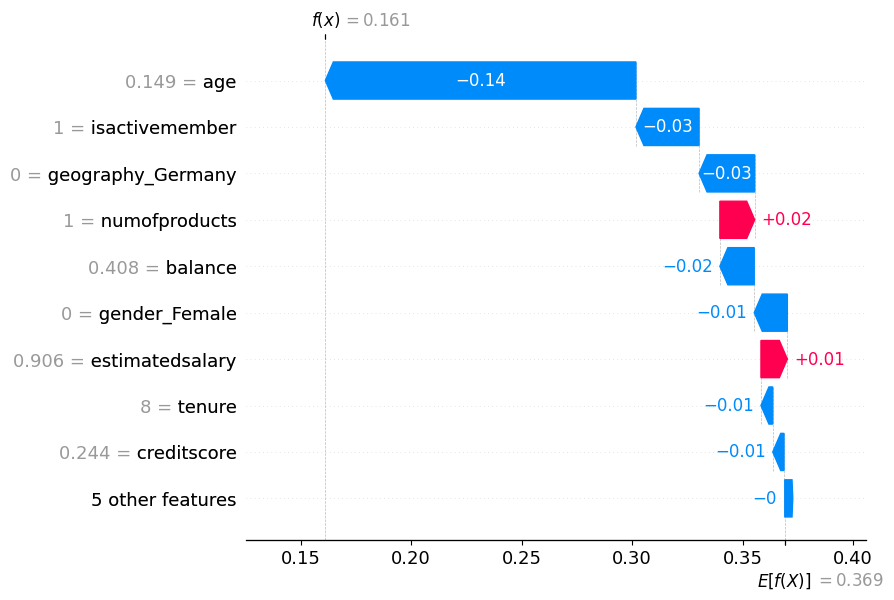

In [95]:
shap.plots.waterfall(shap_values[0])

In [97]:
X_train.shape

(7996, 14)

In [96]:
X_test.shape

(2000, 14)

In [100]:
# sample 500 rows from test data

test_data_sample = X_test.sample(500)

In [101]:
test_data_sample.shape

(500, 14)

In [102]:
# calculate shap values for the entire test data

shap_values = explainer(test_data_sample)

PermutationExplainer explainer: 501it [07:00,  1.17it/s]                         


In [103]:
shap_values.shape

(500, 14)

In [105]:
shap_values

.values =
array([[-0.00353311, -0.0307456 , -0.04265167, ...,  0.000434  ,
         0.03804231, -0.0175854 ],
       [-0.00704273, -0.04503435,  0.00025039, ..., -0.00034788,
        -0.11820595,  0.0046025 ],
       [-0.00075411, -0.10859112, -0.02730319, ..., -0.00092465,
        -0.044478  ,  0.0026476 ],
       ...,
       [-0.02285357,  0.21807819, -0.0093665 , ..., -0.00179432,
         0.06526929,  0.00372527],
       [ 0.01170147, -0.1322856 , -0.00513496, ...,  0.00115361,
         0.04923226,  0.00251413],
       [-0.00434884,  0.108525  , -0.01171342, ...,  0.00197076,
         0.06052363,  0.00398814]], shape=(500, 14))

.base_values =
array([0.36908761, 0.36908761, 0.36908761, 0.36908761, 0.36908761,
       0.36908761, 0.36908761, 0.36908761, 0.36908761, 0.36908761,
       0.36908761, 0.36908761, 0.36908761, 0.36908761, 0.36908761,
       0.36908761, 0.36908761, 0.36908761, 0.36908761, 0.36908761,
       0.36908761, 0.36908761, 0.36908761, 0.36908761, 0.36908761,
       0.

### Global Plots

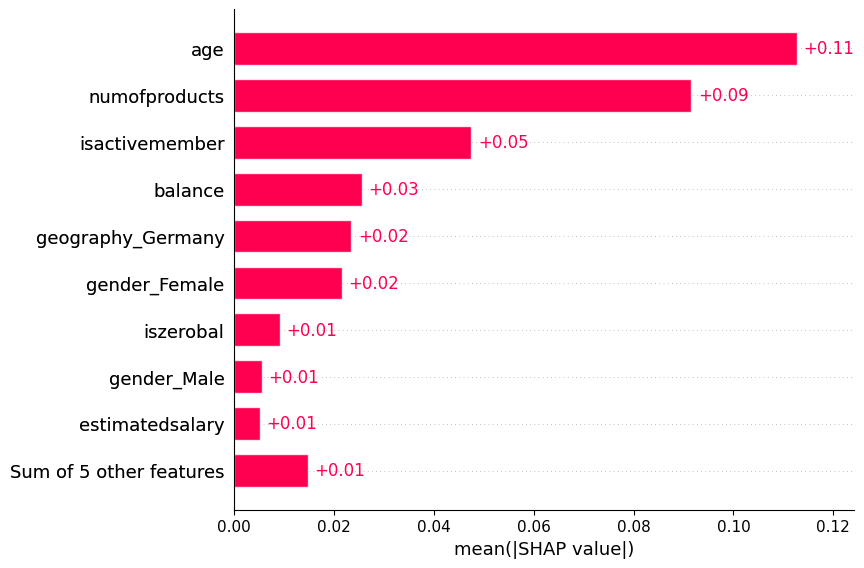

In [106]:
# bar plot

shap.plots.bar(shap_values)

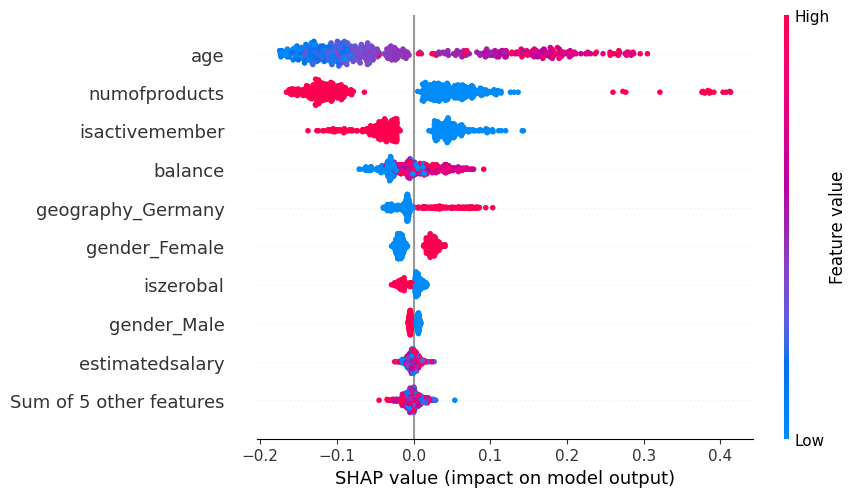

In [107]:
# summary plot

shap.plots.beeswarm(shap_values)

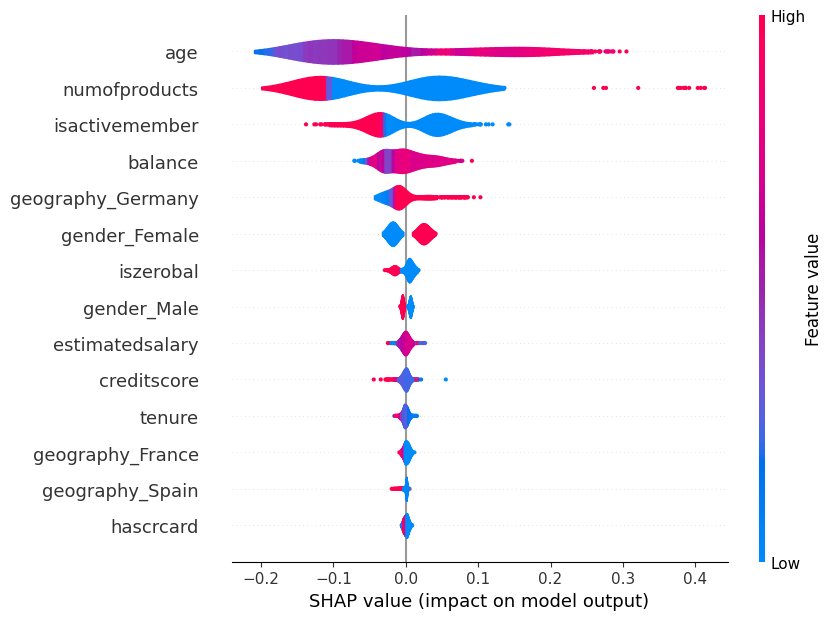

In [108]:
# violin plot

shap.plots.violin(shap_values)

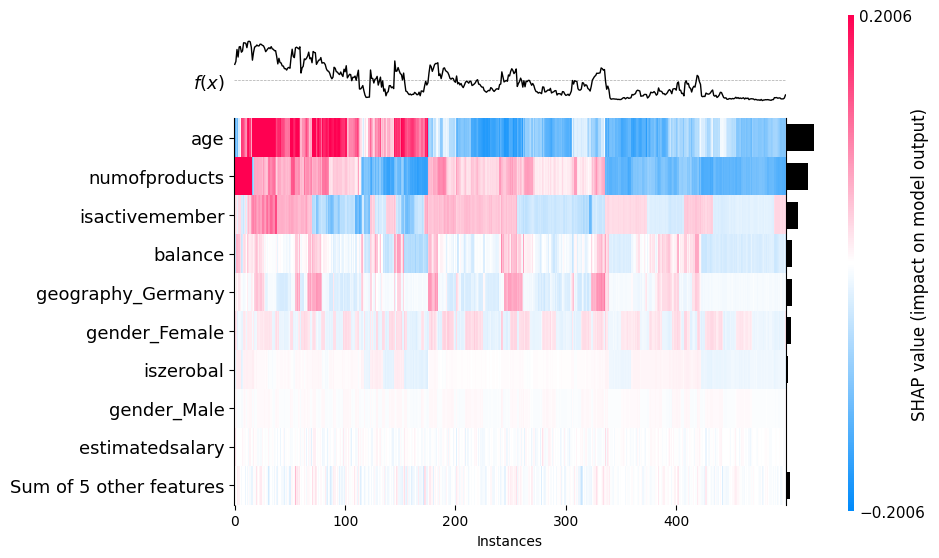

<Axes: xlabel='Instances'>

In [263]:
# heatmap plot

shap.plots.heatmap(shap_values)

### Local Plots

In [220]:
test_case = X_test[y_test == 1].sample(1)

row_shap_values = explainer(test_case)[0]

In [221]:
row_shap_values.shape

(14,)

In [229]:
df.loc[test_case.index]

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
7718,740,France,Female,60.0,5,108028.08,2,0.0,0.0,25980.42,1


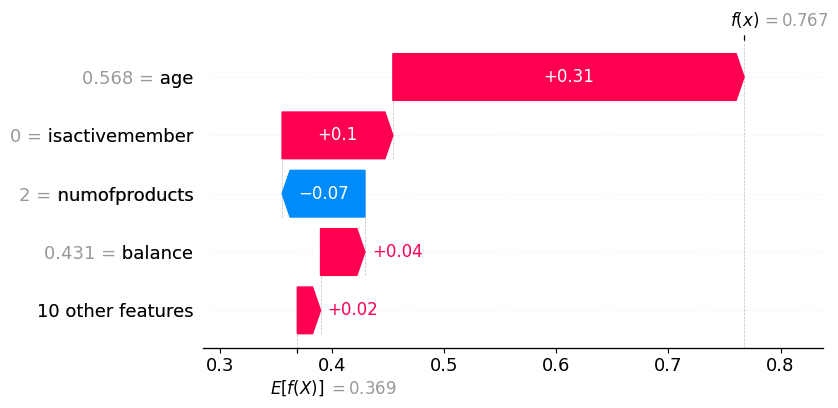

In [264]:
# waterfall plot

shap.plots.waterfall(row_shap_values, max_display=5)

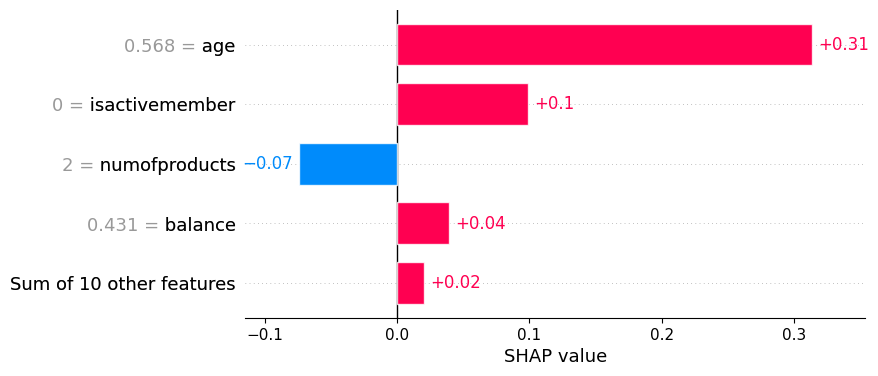

In [265]:
# bar plot--> local

shap.plots.bar(row_shap_values, max_display=5)

In [232]:
# row force plot

shap.initjs()

shap.plots.force(row_shap_values)

In [266]:
row_shap_values

.values =
array([-3.61631235e-03,  3.13190740e-01,  3.95372968e-02, -5.06220010e-03,
        2.40604065e-02,  6.09546101e-03, -2.20198285e-03, -1.16332267e-02,
        2.81804246e-04, -2.64265464e-03, -7.38363669e-02,  5.92234406e-04,
        9.87997447e-02,  1.48403972e-02])

.base_values =
np.float64(0.3690876145926485)

.data =
array([0.78      , 0.56756757, 0.43056557, 0.12987072, 1.        ,
       0.        , 1.        , 0.        , 0.        , 5.        ,
       2.        , 0.        , 0.        , 0.        ])

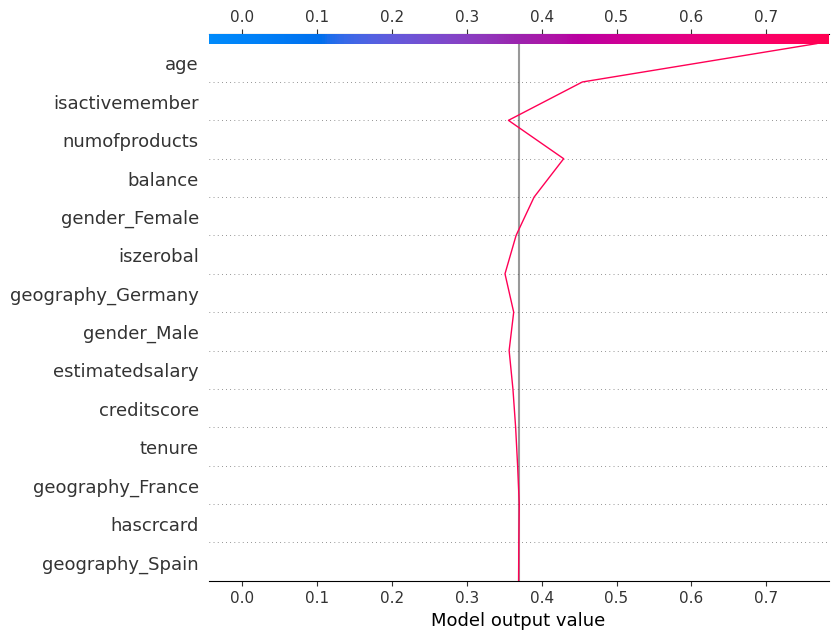

In [245]:
# decision plot

shap.plots.decision(shap_values=row_shap_values.values, base_value=row_shap_values.base_values,
                    feature_names=X_test.columns.tolist())

### Batch Data Plots

In [267]:
# sample of test data
sample_batch_data = X_test.sample(3)

# shap_values
batch_shap_values = explainer(sample_batch_data)

In [268]:
batch_shap_values.shape

(3, 14)

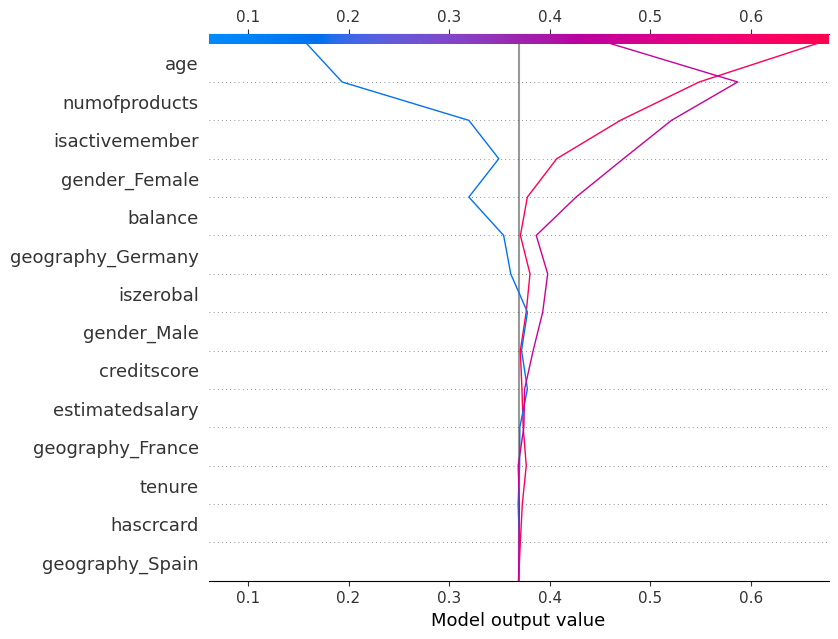

In [269]:
# decision plot

shap.plots.decision(shap_values=batch_shap_values.values, base_value=batch_shap_values.base_values[0],
                    feature_names=X_test.columns.tolist())